In [1]:
# === Global runtime / WSL config ===
import os
import random
import numpy as np

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Tame TensorFlow logging (0=all, 1=INFO, 2=WARNING, 3=ERROR)
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")

print("Runtime seed:", SEED)

Runtime seed: 42


# Lotto XGBoost with 5-Number Buckets (Named Ranges)

This notebook:

1. Loads `Lotto_DATE.xlsx` (NZ Lotto draw history).
2. Builds **5-number bucket features** with meaningful names, e.g. `bucket_1_5_count`, `bucket_6_10_count`, etc.
3. Adds simple extra features (Odd/Even, date parts, etc.).
4. Trains an **XGBoost multi-output regressor** (one target per winning number).
5. Performs 5-fold cross-validation.
6. Demonstrates generating candidate draws and predicting with the best model.
7. Saves the expanded dataset (with new features) as `Lotto_DATE_Imputed.xlsx`.

Place this notebook in the same folder as `Lotto5.xlsx` and run all cells top to bottom.


In [2]:
# === GPU / CUDA environment (WSL) ===
import os
import subprocess

print("=" * 70)
print("WSL GPU / CUDA environment check")
print("=" * 70)

# In WSL, TensorFlow uses the Linux CUDA runtime exposed by the NVIDIA driver.
# We do NOT need or use Windows paths like C:\Program Files\NVIDIA... here.

print(f"Running inside WSL: {os.uname().sysname} {os.uname().release}")
print(f"DISPLAY: {os.environ.get('DISPLAY', 'NOT SET')}")
print(f"LD_LIBRARY_PATH: {os.environ.get('LD_LIBRARY_PATH', 'NOT SET')}")

# Optional: try to call nvidia-smi from within WSL
try:
    result = subprocess.run(
        ["nvidia-smi"],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True,
        check=False,
    )
    print("\n`nvidia-smi` output:")
    print(result.stdout)
except FileNotFoundError:
    print("\n`nvidia-smi` not found in this WSL environment.")
except Exception as e:
    print("\nFailed to run `nvidia-smi` inside WSL:", e)


WSL GPU / CUDA environment check
Running inside WSL: Linux 6.6.87.2-microsoft-standard-WSL2
DISPLAY: :0
LD_LIBRARY_PATH: NOT SET

`nvidia-smi` output:
Tue Dec  2 00:20:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.02              Driver Version: 581.42         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 66%   58C    P0            120W /  350W |    2245MiB /  12288MiB |      1%     

In [3]:
import tensorflow as tf

print("\n" + "=" * 70)
print("TensorFlow GPU Detection & Diagnostics (WSL)")
print("=" * 70)

print(f"TensorFlow version: {tf.__version__}")

print("\nTensorFlow build with CUDA support?:", tf.test.is_built_with_cuda())

# List devices
print("\nAvailable physical devices:")
for device in tf.config.list_physical_devices():
    print(f"  - {device.name} ({device.device_type})")

print("\nGPU devices:")
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        print(f"  - {gpu.name}")
else:
    print("  ⚠ No GPU devices visible to TensorFlow in this WSL session.")

2025-12-02 00:20:35.712750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 00:20:35.722940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 00:20:35.726135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



TensorFlow GPU Detection & Diagnostics (WSL)
TensorFlow version: 2.17.0

TensorFlow build with CUDA support?: True

Available physical devices:
  - /physical_device:CPU:0 (CPU)
  - /physical_device:GPU:0 (GPU)

GPU devices:
  - /physical_device:GPU:0


I0000 00:00:1764588038.128788   13755 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764588038.190609   13755 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764588038.190683   13755 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor

from xgboost import XGBRegressor

np.random.seed(42)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 100)

print('Libraries imported.')

Libraries imported.


In [5]:

# === Rev15: global config for GPU-accelerated XGBoost and fast boosters ===
# Set these flags before training cells (Rev13/Rev14) so they pick up GPU / fast logic.

USE_GPU_XGB = True      # Let Rev13 training try GPU ('gpu_hist') if available
USE_XGB_FAST = True     # Let Rev14 fast per-target boosters train as well

print("Rev15 config: USE_GPU_XGB =", USE_GPU_XGB, "| USE_XGB_FAST =", USE_XGB_FAST)


Rev15 config: USE_GPU_XGB = True | USE_XGB_FAST = True


In [6]:
# === Rev13 config: GPU & ensemble behaviour ===
# Toggle GPU-accelerated XGBoost (will fall back to CPU if unavailable)
USE_GPU_XGB = True

# Ensemble weights when both best_model (real-only) and model_mc (augmented) exist.
# (w_real, w_augmented) - should sum to 1.0
ENSEMBLE_WEIGHTS = (0.3, 0.7)

print(f"Rev13 config -> USE_GPU_XGB={USE_GPU_XGB}, ENSEMBLE_WEIGHTS={ENSEMBLE_WEIGHTS}")

# === Rev14 config: fast GPU XGBoost + GA search ===

# Enable fast per-target GPU XGBoost using DMatrix (in addition to existing sklearn pipelines)
USE_XGB_FAST = True

# Number of boosting rounds for fast models (per target)
XGB_FAST_NUM_BOOST_ROUNDS = 400

# Genetic Algorithm search config
USE_GA_SEARCH = True
GA_POP_SIZE = 120        # population size
GA_NUM_GENERATIONS = 40  # how many generations
GA_MUTATION_RATE = 0.12  # mutation probability per child
GA_CROSSOVER_RATE = 0.85 # probability of crossover

print(f"Rev14 config -> USE_XGB_FAST={USE_XGB_FAST}, USE_GA_SEARCH={USE_GA_SEARCH}")

Rev13 config -> USE_GPU_XGB=True, ENSEMBLE_WEIGHTS=(0.3, 0.7)
Rev14 config -> USE_XGB_FAST=True, USE_GA_SEARCH=True


In [7]:
# Path to your Excel file. Ensure Lotto_2025-11-26.xlsx is in the same directory as this notebook.
excel_path = "Lotto_2025-11-26.xlsx"

df = pd.read_excel(excel_path)
print("Data shape:", df.shape)
display(df.head())
print("\nColumns:", list(df.columns))

Data shape: (1464, 32)


,Draw,Date,Winning Number 1,2,3,4,5,6,Supplementary Number,From Last,Low,High,Odd,Even,1-10,11-20,21-30,31-40,Division 1 Winners,Division 1 Prize,Division 2 Winners,Division 2 Prize,Division 3 Winners,Division 3 Prize,Division 4 Winners,Division 4 Prize,Division 5 Winners,Division 5 Prize,Division 6 Winners,Division 6 Prize,Division 7 Winners,Division 7 Prize
0,2537,2025-11-26,4,5,9,21,32,34,3,NaN,3,3,3,3,3,0,1,2,2.0,500000.0,13.0,16290.0,300.0,700.0,802.0,60.0,12979.0,32.0,18258.0,22.0,185398.0,1.5
1,2536,2025-11-22,2,6,10,12,28,30,22,"2,10",4,2,0,6,3,1,2,0,5.0,200000.0,22.0,11489.0,548.0,457.0,1372.0,42.0,20291.0,25.0,26709.0,18.0,254719.0,1.5
2,2535,2025-11-19,2,10,18,25,29,31,21,2,3,3,3,3,2,1,2,1,0.0,0.0,15.0,16772.0,423.0,590.0,1088.0,53.0,17552.0,28.0,22725.0,21.0,232598.0,1.5
3,2534,2025-11-15,2,5,14,19,28,38,29,19,4,2,2,4,2,2,1,1,18.0,55556.0,62.0,16909.0,1777.0,585.0,4196.0,57.0,68364.0,30.0,89904.0,23.0,952797.0,1.5
4,2533,2025-11-12,4,10,18,19,27,30,32,4,4,2,2,4,2,2,2,0,6.0,166667.0,20.0,32541.0,1172.0,551.0,2489.0,59.0,46570.0,28.0,56635.0,22.0,626052.0,1.5



Columns: ['Draw', 'Date', 'Winning Number 1', '2', '3', '4', '5', '6', 'Supplementary Number', 'From Last', 'Low', 'High', 'Odd', 'Even', '1-10', '11-20', '21-30', '31-40', 'Division 1 Winners', 'Division 1 Prize', 'Division 2 Winners', 'Division 2 Prize', 'Division 3 Winners', 'Division 3 Prize', 'Division 4 Winners', 'Division 4 Prize', 'Division 5 Winners', 'Division 5 Prize', 'Division 6 Winners', 'Division 6 Prize', 'Division 7 Winners', 'Division 7 Prize']


## Basic cleaning and helper columns

We:

- Ensure the winning number columns are numeric.
- Convert helper columns like `From Last`, `Same As Day`, `Odd`, `Even` to numeric (if present).
- Parse `Date` and add simple date features.


In [8]:
# Winning number columns (targets)
# In Lotto_2025-11-26.xlsx the first column is "Winning Number 1"
# and the remaining winning numbers are in columns "2", "3", "4", "5", "6".
number_cols = [
    "Winning Number 1",
    "2",
    "3",
    "4",
    "5",
    "6",
]

# Ensure numeric for winning numbers
for col in number_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    else:
        raise ValueError(f"Expected column '{col}' not found in dataframe.")

# Helper columns that may exist
helper_cols = ["From Last", "Same As Day", "Odd", "Even"]
for col in helper_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Date handling
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df["Year"] = df["Date"].dt.year.fillna(0).astype(int)
    df["Month"] = df["Date"].dt.month.fillna(0).astype(int)
    df["DayOfWeek"] = df["Date"].dt.dayofweek.fillna(0).astype(int)
else:
    df["Year"] = 0
    df["Month"] = 0
    df["DayOfWeek"] = 0

print("After basic cleaning:")
display(df.head())

After basic cleaning:


,Draw,Date,Winning Number 1,2,3,4,5,6,Supplementary Number,From Last,Low,High,Odd,Even,1-10,11-20,21-30,31-40,Division 1 Winners,Division 1 Prize,Division 2 Winners,Division 2 Prize,Division 3 Winners,Division 3 Prize,Division 4 Winners,Division 4 Prize,Division 5 Winners,Division 5 Prize,Division 6 Winners,Division 6 Prize,Division 7 Winners,Division 7 Prize,Year,Month,DayOfWeek
0,2537,2025-11-26,4,5,9,21,32,34,3,NaN,3,3,3,3,3,0,1,2,2.0,500000.0,13.0,16290.0,300.0,700.0,802.0,60.0,12979.0,32.0,18258.0,22.0,185398.0,1.5,2025,11,2
1,2536,2025-11-22,2,6,10,12,28,30,22,NaN,4,2,0,6,3,1,2,0,5.0,200000.0,22.0,11489.0,548.0,457.0,1372.0,42.0,20291.0,25.0,26709.0,18.0,254719.0,1.5,2025,11,5
2,2535,2025-11-19,2,10,18,25,29,31,21,2.0,3,3,3,3,2,1,2,1,0.0,0.0,15.0,16772.0,423.0,590.0,1088.0,53.0,17552.0,28.0,22725.0,21.0,232598.0,1.5,2025,11,2
3,2534,2025-11-15,2,5,14,19,28,38,29,19.0,4,2,2,4,2,2,1,1,18.0,55556.0,62.0,16909.0,1777.0,585.0,4196.0,57.0,68364.0,30.0,89904.0,23.0,952797.0,1.5,2025,11,5
4,2533,2025-11-12,4,10,18,19,27,30,32,4.0,4,2,2,4,2,2,2,0,6.0,166667.0,20.0,32541.0,1172.0,551.0,2489.0,59.0,46570.0,28.0,56635.0,22.0,626052.0,1.5,2025,11,2


## 5-number bucket features with named ranges

We map numbers as follows (for NZ Lotto 1–40):

- 1–5   → bucket index 0 → features: `bucket_1_5_count`, `bucket_1_5_present`
- 6–10  → bucket index 1 → `bucket_6_10_count`, ...
- 11–15 → bucket index 2
- 16–20 → bucket index 3
- 21–25 → bucket index 4
- 26–30 → bucket index 5
- 31–35 → bucket index 6
- 36–40 → bucket index 7

So you can immediately see which 5-number range each feature refers to.


In [9]:
def num_to_bucket(num: float, bucket_size: int = 5) -> float:
    """Map a lotto number to a 0-based bucket index of size `bucket_size`.
    Returns NaN for missing values.
    """
    if pd.isna(num):
        return np.nan
    return int((int(num) - 1) // bucket_size)

# Create per-number bucket columns (indices)
for col in number_cols:
    df[f"{col}_bucket"] = df[col].apply(num_to_bucket)

bucket_cols = [f"{col}_bucket" for col in number_cols]
max_bucket = int(df[bucket_cols].max().max())

# Infer max actual number from data (e.g. 40)
max_number = int(df[number_cols].max().max())
bucket_size = 5

# Build mapping from bucket index -> human-readable column names
bucket_index_to_count_col = {}
bucket_index_to_present_col = {}
bucket_count_cols = []
bucket_present_cols = []

for i in range(max_bucket + 1):
    low = i * bucket_size + 1
    high = min((i + 1) * bucket_size, max_number)
    count_name = f"bucket_{low}_{high}_count"
    present_name = f"bucket_{low}_{high}_present"
    bucket_index_to_count_col[i] = count_name
    bucket_index_to_present_col[i] = present_name
    bucket_count_cols.append(count_name)
    bucket_present_cols.append(present_name)

print("Bucket index to feature names:")
for i in range(max_bucket + 1):
    print(i, "->", bucket_index_to_count_col[i], ",", bucket_index_to_present_col[i])

display(df[bucket_cols].head())

Bucket index to feature names:
0 -> bucket_1_5_count , bucket_1_5_present
1 -> bucket_6_10_count , bucket_6_10_present
2 -> bucket_11_15_count , bucket_11_15_present
3 -> bucket_16_20_count , bucket_16_20_present
4 -> bucket_21_25_count , bucket_21_25_present
5 -> bucket_26_30_count , bucket_26_30_present
6 -> bucket_31_35_count , bucket_31_35_present
7 -> bucket_36_40_count , bucket_36_40_present


,Winning Number 1_bucket,2_bucket,3_bucket,4_bucket,5_bucket,6_bucket
0,0,0,1,4,6,6
1,0,1,1,2,5,5
2,0,1,3,4,5,6
3,0,0,2,3,5,7
4,0,1,3,3,5,5


In [10]:
# Compute bucket counts per draw using the named columns
def bucket_count_row(row):
    counts = np.zeros(max_bucket + 1, dtype=int)
    buckets = row[bucket_cols].values
    for b in buckets:
        if not pd.isna(b):
            b_int = int(b)
            if 0 <= b_int <= max_bucket:
                counts[b_int] += 1
    # Map counts into named columns
    data = {}
    for i in range(max_bucket + 1):
        data[bucket_index_to_count_col[i]] = counts[i]
    return pd.Series(data, index=bucket_count_cols)

df_bucket_counts = df.apply(bucket_count_row, axis=1)
df = pd.concat([df, df_bucket_counts], axis=1)

# Presence flags using named columns
for i in range(max_bucket + 1):
    count_col = bucket_index_to_count_col[i]
    present_col = bucket_index_to_present_col[i]
    df[present_col] = (df[count_col] > 0).astype(int)

# Bucket energy (weighted sum of bucket indices by count)
df["bucket_energy"] = 0
for i in range(max_bucket + 1):
    count_col = bucket_index_to_count_col[i]
    df["bucket_energy"] += i * df[count_col]

print("Bucket features created (named ranges):")
display(df.head())

Bucket features created (named ranges):


,Draw,Date,Winning Number 1,2,3,4,5,6,Supplementary Number,From Last,Low,High,Odd,Even,1-10,11-20,21-30,31-40,Division 1 Winners,Division 1 Prize,Division 2 Winners,Division 2 Prize,Division 3 Winners,Division 3 Prize,Division 4 Winners,Division 4 Prize,Division 5 Winners,Division 5 Prize,Division 6 Winners,Division 6 Prize,Division 7 Winners,Division 7 Prize,Year,Month,DayOfWeek,Winning Number 1_bucket,2_bucket,3_bucket,4_bucket,5_bucket,6_bucket,bucket_1_5_count,bucket_6_10_count,bucket_11_15_count,bucket_16_20_count,bucket_21_25_count,bucket_26_30_count,bucket_31_35_count,bucket_36_40_count,bucket_1_5_present,bucket_6_10_present,bucket_11_15_present,bucket_16_20_present,bucket_21_25_present,bucket_26_30_present,bucket_31_35_present,bucket_36_40_present,bucket_energy
0,2537,2025-11-26,4,5,9,21,32,34,3,NaN,3,3,3,3,3,0,1,2,2.0,500000.0,13.0,16290.0,300.0,700.0,802.0,60.0,12979.0,32.0,18258.0,22.0,185398.0,1.5,2025,11,2,0,0,1,4,6,6,2,1,0,0,1,0,2,0,1,1,0,0,1,0,1,0,17
1,2536,2025-11-22,2,6,10,12,28,30,22,NaN,4,2,0,6,3,1,2,0,5.0,200000.0,22.0,11489.0,548.0,457.0,1372.0,42.0,20291.0,25.0,26709.0,18.0,254719.0,1.5,2025,11,5,0,1,1,2,5,5,1,2,1,0,0,2,0,0,1,1,1,0,0,1,0,0,14
2,2535,2025-11-19,2,10,18,25,29,31,21,2.0,3,3,3,3,2,1,2,1,0.0,0.0,15.0,16772.0,423.0,590.0,1088.0,53.0,17552.0,28.0,22725.0,21.0,232598.0,1.5,2025,11,2,0,1,3,4,5,6,1,1,0,1,1,1,1,0,1,1,0,1,1,1,1,0,19
3,2534,2025-11-15,2,5,14,19,28,38,29,19.0,4,2,2,4,2,2,1,1,18.0,55556.0,62.0,16909.0,1777.0,585.0,4196.0,57.0,68364.0,30.0,89904.0,23.0,952797.0,1.5,2025,11,5,0,0,2,3,5,7,2,0,1,1,0,1,0,1,1,0,1,1,0,1,0,1,17
4,2533,2025-11-12,4,10,18,19,27,30,32,4.0,4,2,2,4,2,2,2,0,6.0,166667.0,20.0,32541.0,1172.0,551.0,2489.0,59.0,46570.0,28.0,56635.0,22.0,626052.0,1.5,2025,11,2,0,1,3,3,5,5,1,1,0,2,0,2,0,0,1,1,0,1,0,1,0,0,17


In [11]:
# Save expanded dataset with new features
output_excel_path = "Lotto_2025-11-26_Imputed.xlsx"
df.to_excel(output_excel_path, index=False)
print(f"Saved dataset with new features to {output_excel_path}")

Saved dataset with new features to Lotto_2025-11-26_Imputed.xlsx


## Build feature matrix and target matrix

- **Targets**: the six winning numbers as a 6D regression target.
- **Features**: named bucket counts/presence, bucket energy, helper columns, and date parts.


In [12]:
target_cols = number_cols.copy()

# bucket_count_cols and bucket_present_cols already defined with meaningful names
candidate_feature_cols = (
    bucket_count_cols
    + bucket_present_cols
    + ["bucket_energy", "From Last", "Same As Day", "Odd", "Even", "Year", "Month", "DayOfWeek"]
)

# Keep only columns that exist in df (in case some helper cols are missing)
feature_cols = [c for c in candidate_feature_cols if c in df.columns]

print("Using feature columns:")
print(feature_cols)

X = df[feature_cols].values
y = df[target_cols].values

print("Feature matrix shape:", X.shape)
print("Target matrix shape:", y.shape)

Using feature columns:
['bucket_1_5_count', 'bucket_6_10_count', 'bucket_11_15_count', 'bucket_16_20_count', 'bucket_21_25_count', 'bucket_26_30_count', 'bucket_31_35_count', 'bucket_36_40_count', 'bucket_1_5_present', 'bucket_6_10_present', 'bucket_11_15_present', 'bucket_16_20_present', 'bucket_21_25_present', 'bucket_26_30_present', 'bucket_31_35_present', 'bucket_36_40_present', 'bucket_energy', 'From Last', 'Odd', 'Even', 'Year', 'Month', 'DayOfWeek']
Feature matrix shape: (1464, 23)
Target matrix shape: (1464, 6)


# === Rev13: XGBoost training on real data with optional GPU ===

# Base XGBoost parameters
xgb_params = dict(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    tree_method="hist",   # default CPU
    random_state=42,
)

# Try to enable GPU if configured
if 'USE_GPU_XGB' in globals() and USE_GPU_XGB:
    try:
        import xgboost as xgb  # just to confirm GPU build is available
        xgb_params["tree_method"] = "gpu_hist"
        xgb_params["predictor"] = "gpu_predictor"
        print("Using GPU-accelerated XGBoost (tree_method='gpu_hist').")
    except Exception as e:
        print("GPU XGBoost not available, falling back to CPU 'hist'. Reason:", e)

xgb_reg = XGBRegressor(**xgb_params)

model = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("regressor", MultiOutputRegressor(xgb_reg)),
    ]
)

# Use MSE as the scoring metric (negative for cross_validate)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

cv_results = cross_validate(
    model,
    X,
    y,
    cv=5,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1,
)

test_scores = -cv_results["test_score"]  # convert back to positive MSE
print("Cross-validation MSE scores:", test_scores)
print("Mean CV MSE:", np.mean(test_scores))

best_model_index = np.argmin(test_scores)
best_model = cv_results["estimator"][best_model_index]
print("Best model index:", best_model_index)
print("Best model trained (real draws only) and stored as 'best_model'.")

In [13]:

# === Rev14: optional fast per-target GPU XGBoost using DMatrix ===
# This does NOT replace the existing sklearn-based models; it adds an extra
# set of boosters (one per output) that we can use for analysis or GA fitness.

fast_models = None
fast_feature_names = None

if 'USE_XGB_FAST' in globals() and USE_XGB_FAST:
    try:
        import xgboost as xgb

        print("Training fast per-target XGBoost models (Rev14)...")

        # Ensure X and y are numpy arrays
        X_np = X.values if hasattr(X, "values") else X
        y_np = y.values if hasattr(y, "values") else y

        n_targets = y_np.shape[1]
        fast_models = []
        fast_feature_names = list(feature_cols)

        base_params = {
            "max_depth": 4,
            "eta": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "objective": "reg:squarederror",
            "tree_method": "hist",
            "seed": 42,
        }

        # Try GPU
        if 'USE_GPU_XGB' in globals() and USE_GPU_XGB:
            base_params["tree_method"] = "gpu_hist"
            base_params["predictor"] = "gpu_predictor"

        num_boost_round = int(XGB_FAST_NUM_BOOST_ROUNDS) if "XGB_FAST_NUM_BOOST_ROUNDS" in globals() else 400

        for t in range(n_targets):
            print(f"  Training fast model for target {t+1}/{n_targets}...")
            dtrain = xgb.DMatrix(X_np, label=y_np[:, t], feature_names=fast_feature_names)
            booster = xgb.train(
                params=base_params,
                dtrain=dtrain,
                num_boost_round=num_boost_round,
                verbose_eval=False,
            )
            fast_models.append(booster)

        print(f"Trained {len(fast_models)} fast XGBoost models.")
    except Exception as e:
        print("Fast XGB training skipped due to error:", e)
        fast_models = None
        fast_feature_names = None
else:
    print("USE_XGB_FAST is False; skipping fast XGBoost training for Rev14.")


Training fast per-target XGBoost models (Rev14)...
  Training fast model for target 1/6...
  Training fast model for target 2/6...
  Training fast model for target 3/6...
  Training fast model for target 4/6...
  Training fast model for target 5/6...
  Training fast model for target 6/6...
Trained 6 fast XGBoost models.


In [14]:
# Define base XGBoost regressor
xgb_reg = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    tree_method="hist",  # change to 'gpu_hist' if you have GPU XGBoost installed
    random_state=42,
)

model = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("regressor", MultiOutputRegressor(xgb_reg)),
    ]
)

scoring = make_scorer(mean_squared_error, greater_is_better=False)

cv_results = cross_validate(
    model,
    X,
    y,
    cv=5,
    scoring=scoring,
    return_estimator=True,
    n_jobs=-1,
)

test_scores = -cv_results["test_score"]  # convert back to positive MSE
print("Cross-validation MSE scores:", test_scores)
print("Mean CV MSE:", np.mean(test_scores))

best_model_index = np.argmin(test_scores)
best_model = cv_results["estimator"][best_model_index]
print("Best model index:", best_model_index)

Cross-validation MSE scores: [2.42727407 2.269439   2.38645407 2.23451143 2.39193601]
Mean CV MSE: 2.3419229152284466
Best model index: 3


## Predicting from candidate draws

To keep things simple, we:

1. Generate a **candidate draw** (6 random numbers 1–40, no replacement).
2. Build the same **bucket-based features** (with named ranges) for that draw.
3. Use the best cross-validated model to predict a 6D output.
4. Map predictions back into the 1–40 range (wrapping with modulo).

This is more for exploration / "pattern resonance" than real prediction.


In [15]:

# === Rev14: helper for fast model prediction given a single feature row ===

def fast_models_predict(input_row):
    """Predict 6 outputs using the fast per-target boosters.
    input_row: 1D array-like or single-row DataFrame in feature_cols order.
    Returns a numpy array of shape (6,).
    """
    if fast_models is None or fast_feature_names is None:
        raise RuntimeError("fast_models are not trained or fast_feature_names missing.")

    import numpy as np
    import xgboost as xgb

    if hasattr(input_row, "values"):
        arr = input_row.values.astype(float).reshape(1, -1)
    else:
        arr = np.asarray(input_row, dtype=float).reshape(1, -1)

    dtest = xgb.DMatrix(arr, feature_names=fast_feature_names)

    preds = []
    for booster in fast_models:
        preds.append(booster.predict(dtest)[0])
    return np.array(preds)


In [16]:
def build_features_from_draw(draw_numbers, feature_columns, max_bucket_local=None, bucket_size_local=5):
    """Build a one-row feature DataFrame for a candidate draw using the same
    bucket logic and feature columns as the training data.
    """
    draw_numbers = np.array(draw_numbers, dtype=int)
    if max_bucket_local is None:
        max_bucket_local = max_bucket

    # bucket counts
    counts = np.zeros(max_bucket_local + 1, dtype=int)
    for n in draw_numbers:
        b = num_to_bucket(n, bucket_size=bucket_size_local)
        if 0 <= b <= max_bucket_local:
            counts[b] += 1

    row = {}

    # bucket counts and presence using named columns
    for i in range(max_bucket_local + 1):
        count_col = bucket_index_to_count_col[i]
        present_col = bucket_index_to_present_col[i]
        if count_col in feature_columns:
            row[count_col] = counts[i]
        if present_col in feature_columns:
            row[present_col] = int(counts[i] > 0)

    # bucket_energy
    if "bucket_energy" in feature_columns:
        row["bucket_energy"] = sum(i * counts[i] for i in range(max_bucket_local + 1))

    # draw-level stats (only if these columns exist in the model)
    if "draw_median" in feature_columns:
        row["draw_median"] = float(np.median(draw_numbers))
    if "draw_mean" in feature_columns:
        row["draw_mean"] = float(np.mean(draw_numbers))
    if "draw_min" in feature_columns:
        row["draw_min"] = int(np.min(draw_numbers))
    if "draw_max" in feature_columns:
        row["draw_max"] = int(np.max(draw_numbers))

    # Odd / Even counts (if used as features)
    if "Odd" in feature_columns:
        row["Odd"] = int((draw_numbers % 2 != 0).sum())
    if "Even" in feature_columns:
        row["Even"] = int((draw_numbers % 2 == 0).sum())

    # helper + date features (neutral defaults if present in training)
    defaults = {
        "From Last": 0,
        "Same As Day": 0,
        "Year": 0,
        "Month": 0,
        "DayOfWeek": 0,
    }
    for col, val in defaults.items():
        if col in feature_columns and col not in row:
            row[col] = val

    # ensure all feature_columns exist
    for col in feature_columns:
        if col not in row:
            row[col] = 0

    return pd.DataFrame([row], columns=feature_columns)


def sanitize_prediction(raw_pred, n_numbers=6, low=1, high=40):
    """Convert raw model outputs into a valid NZ Lotto line:
    - Round to ints
    - Wrap into [low, high] range
    - Enforce uniqueness (no duplicates)
    - Return sorted array of length n_numbers
    """
    # Map floats to ints in the valid range
    ints = ((np.round(raw_pred).astype(int) - 1) % high) + low
    ints = np.clip(ints, low, high)

    # Enforce uniqueness
    uniq = np.unique(ints)

    # If we have fewer than required, sample extra distinct numbers
    if len(uniq) < n_numbers:
        remaining = np.setdiff1d(np.arange(low, high + 1), uniq)
        extra = np.random.choice(remaining, size=n_numbers - len(uniq), replace=False)
        uniq = np.sort(np.concatenate([uniq, extra]))
    # If we have more, truncate to the first n_numbers
    elif len(uniq) > n_numbers:
        uniq = np.sort(uniq)[:n_numbers]
    else:
        uniq = np.sort(uniq)

    return uniq


# Example: generate a few candidate draws and predict
num_predictions = 5
for i in range(num_predictions):
    candidate_numbers = np.sort(np.random.choice(np.arange(1, 41), size=6, replace=False))
    input_df = build_features_from_draw(candidate_numbers, feature_cols)

    # Prefer ensemble if both models exist; otherwise fall back gracefully
    if "best_model" in globals() and "model_mc" in globals():
        # Use configured ensemble weights if available, else default 0.3/0.7
        if "ENSEMBLE_WEIGHTS" in globals():
            w_base, w_aug = ENSEMBLE_WEIGHTS
        else:
            w_base, w_aug = 0.3, 0.7

        pred_base = best_model.predict(input_df.values)[0]
        pred_aug = model_mc.predict(input_df.values)[0]
        pred = w_base * pred_base + w_aug * pred_aug
        model_used = f"ensemble (w_real={w_base:.2f}, w_aug={w_aug:.2f})"
    elif "model_mc" in globals():
        pred = model_mc.predict(input_df.values)[0]
        model_used = "model_mc (augmented)"
    else:
        pred = best_model.predict(input_df.values)[0]
        model_used = "best_model (original CV best)"
    predicted_numbers = sanitize_prediction(pred, n_numbers=6, low=1, high=40)

    print(f"Prediction set {i+1} using {model_used}:")
    print("  Candidate base numbers:", candidate_numbers)
    print("  Model predicted numbers:", predicted_numbers)
    print("-" * 60)

Prediction set 1 using best_model (original CV best):
  Candidate base numbers: [ 5 13 16 17 20 27]
  Model predicted numbers: [ 2 14 17 20 29 34]
------------------------------------------------------------
Prediction set 2 using best_model (original CV best):
  Candidate base numbers: [ 2  4  5  6 17 27]
  Model predicted numbers: [ 1  3  5  9 17 27]
------------------------------------------------------------
Prediction set 3 using best_model (original CV best):
  Candidate base numbers: [ 2  4  6 18 19 32]
  Model predicted numbers: [ 1  5  9 15 21 34]
------------------------------------------------------------
Prediction set 4 using best_model (original CV best):
  Candidate base numbers: [ 5  8 14 16 24 37]
  Model predicted numbers: [ 2  8 14 17 23 39]
------------------------------------------------------------
Prediction set 5 using best_model (original CV best):
  Candidate base numbers: [ 9 13 16 18 23 33]
  Model predicted numbers: [ 7 14 16 19 24 34]
---------------------

## Monte Carlo Lotto Simulator, Bucket Energy & Delta Export

This section:

- Reuses the existing 5-number bucket logic.
- Computes additional draw-level features like `draw_median`, `draw_mean`, `draw_min`, `draw_max`.
- Visualises **bucket energy** and **median** over time.
- Builds an **empirical + uniform blended Monte Carlo simulator** to generate many synthetic draws.
- Computes the same bucket features for synthetic draws.
- Optionally saves both real and synthetic feature tables to **Delta Lake** for ROAPI or other tools.


In [17]:
# Use the existing dataframe `df` and `number_cols` from earlier cells.
# If your raw draws dataframe has a different name, adjust `df_draws` accordingly.
df_draws = df  # alias for clarity

number_cols = number_cols  # ensure we use the same target columns

print("Using number columns:", number_cols)

def compute_bucket_features_for_draws(df_base: pd.DataFrame) -> pd.DataFrame:
    """Compute bucket count/presence, bucket_energy and draw-level stats for each draw.
    Also computes additional structural stats:
    - draw_median / mean / min / max
    - Odd / Even counts
    - mean_gap / median_gap / std_gap between sorted numbers
    - decade_transitions: how often we cross to a new decade band (1–10, 11–20, ...)
    - gap_entropy: normalized entropy of the gap distribution
    """
    df_feat = df_base.copy()

    # Map each number to a bucket index using existing num_to_bucket
    bucket_indices = df_feat[number_cols].applymap(num_to_bucket)

    # Count per bucket into the named bucket_*_count columns
    def row_to_bucket_counts(row):
        counts = np.zeros(max_bucket + 1, dtype=int)
        for b in row:
            if pd.notnull(b):
                b_int = int(b)
                if 0 <= b_int <= max_bucket:
                    counts[b_int] += 1
        data = {}
        for i in range(max_bucket + 1):
            data[bucket_index_to_count_col[i]] = counts[i]
        return pd.Series(data, index=bucket_count_cols)

    df_counts = bucket_indices.apply(row_to_bucket_counts, axis=1)
    df_feat[df_counts.columns] = df_counts

    # Presence flags using named columns
    for i in range(max_bucket + 1):
        count_col = bucket_index_to_count_col[i]
        present_col = bucket_index_to_present_col[i]
        if count_col in df_feat.columns:
            df_feat[present_col] = (df_feat[count_col] > 0).astype(int)

    # bucket_energy from bucket index * count
    df_feat["bucket_energy"] = 0
    for i in range(max_bucket + 1):
        count_col = bucket_index_to_count_col[i]
        if count_col in df_feat.columns:
            df_feat["bucket_energy"] += i * df_feat[count_col]

    # Draw-level stats from the actual numbers
    df_feat["draw_median"] = df_feat[number_cols].median(axis=1)
    df_feat["draw_mean"] = df_feat[number_cols].mean(axis=1)
    df_feat["draw_min"] = df_feat[number_cols].min(axis=1)
    df_feat["draw_max"] = df_feat[number_cols].max(axis=1)

    # Odd / Even counts
    df_feat["Odd"] = df_feat[number_cols].apply(lambda r: (r % 2 != 0).sum(), axis=1)
    df_feat["Even"] = df_feat[number_cols].apply(lambda r: (r % 2 == 0).sum(), axis=1)

    # Extra line-level structural stats: gaps, decade transitions, gap entropy
    def compute_line_extra_stats(row):
        vals = row.values.astype(float)
        vals = vals[~np.isnan(vals)]
        if len(vals) == 0:
            return pd.Series({
                "mean_gap": np.nan,
                "median_gap": np.nan,
                "std_gap": np.nan,
                "decade_transitions": np.nan,
                "gap_entropy": np.nan,
            })
        vals_sorted = np.sort(vals)
        if len(vals_sorted) > 1:
            gaps = np.diff(vals_sorted)
        else:
            gaps = np.array([0.0])

        mean_gap = float(np.mean(gaps))
        median_gap = float(np.median(gaps))
        std_gap = float(np.std(gaps, ddof=0))

        # decade bands: 1–10 -> 0, 11–20 -> 1, etc.
        decades = ((vals_sorted - 1) // 10).astype(int)
        if len(decades) > 1:
            decade_transitions = int(np.count_nonzero(np.diff(decades) != 0))
        else:
            decade_transitions = 0

        # gap entropy (normalized)
        if len(gaps) > 0:
            uniq, counts = np.unique(gaps, return_counts=True)
            probs = counts.astype(float) / counts.sum()
            ent = -np.sum(probs * np.log(probs))
            if len(probs) > 1:
                gap_entropy = float(ent / np.log(len(probs)))
            else:
                gap_entropy = 0.0
        else:
            gap_entropy = 0.0

        return pd.Series({
            "mean_gap": mean_gap,
            "median_gap": median_gap,
            "std_gap": std_gap,
            "decade_transitions": float(decade_transitions),
            "gap_entropy": gap_entropy,
        })

    extra = df_feat[number_cols].apply(compute_line_extra_stats, axis=1)
    df_feat[extra.columns] = extra

    return df_feat

df_real_feat = compute_bucket_features_for_draws(df_draws)
print("Real feature table shape:", df_real_feat.shape)
df_real_feat.head()

Using number columns: ['Winning Number 1', '2', '3', '4', '5', '6']
Real feature table shape: (1464, 67)


,Draw,Date,Winning Number 1,2,3,4,5,6,Supplementary Number,From Last,Low,High,Odd,Even,1-10,11-20,21-30,31-40,Division 1 Winners,Division 1 Prize,Division 2 Winners,Division 2 Prize,Division 3 Winners,Division 3 Prize,Division 4 Winners,Division 4 Prize,Division 5 Winners,Division 5 Prize,Division 6 Winners,Division 6 Prize,Division 7 Winners,Division 7 Prize,Year,Month,DayOfWeek,Winning Number 1_bucket,2_bucket,3_bucket,4_bucket,5_bucket,6_bucket,bucket_1_5_count,bucket_6_10_count,bucket_11_15_count,bucket_16_20_count,bucket_21_25_count,bucket_26_30_count,bucket_31_35_count,bucket_36_40_count,bucket_1_5_present,bucket_6_10_present,bucket_11_15_present,bucket_16_20_present,bucket_21_25_present,bucket_26_30_present,bucket_31_35_present,bucket_36_40_present,bucket_energy,draw_median,draw_mean,draw_min,draw_max,mean_gap,median_gap,std_gap,decade_transitions,gap_entropy
0,2537,2025-11-26,4,5,9,21,32,34,3,NaN,3,3,3,3,3,0,1,2,2.0,500000.0,13.0,16290.0,300.0,700.0,802.0,60.0,12979.0,32.0,18258.0,22.0,185398.0,1.5,2025,11,2,0,0,1,4,6,6,2,1,0,0,1,0,2,0,1,1,0,0,1,0,1,0,17,15.0,17.500000,4,34,6.0,4.0,4.604346,2.0,1.000000
1,2536,2025-11-22,2,6,10,12,28,30,22,NaN,4,2,0,6,3,1,2,0,5.0,200000.0,22.0,11489.0,548.0,457.0,1372.0,42.0,20291.0,25.0,26709.0,18.0,254719.0,1.5,2025,11,5,0,1,1,2,5,5,1,2,1,0,0,2,0,0,1,1,1,0,0,1,0,0,14,11.0,14.666667,2,30,5.6,4.0,5.276362,2.0,0.960230
2,2535,2025-11-19,2,10,18,25,29,31,21,2.0,3,3,3,3,2,1,2,1,0.0,0.0,15.0,16772.0,423.0,590.0,1088.0,53.0,17552.0,28.0,22725.0,21.0,232598.0,1.5,2025,11,2,0,1,3,4,5,6,1,1,0,1,1,1,1,0,1,1,0,1,1,1,1,0,19,21.5,19.166667,2,31,5.8,7.0,2.400000,3.0,0.960964
3,2534,2025-11-15,2,5,14,19,28,38,29,19.0,4,2,2,4,2,2,1,1,18.0,55556.0,62.0,16909.0,1777.0,585.0,4196.0,57.0,68364.0,30.0,89904.0,23.0,952797.0,1.5,2025,11,5,0,0,2,3,5,7,2,0,1,1,0,1,0,1,1,0,1,1,0,1,0,1,17,16.5,17.666667,2,38,7.2,9.0,2.712932,3.0,0.960964
4,2533,2025-11-12,4,10,18,19,27,30,32,4.0,4,2,2,4,2,2,2,0,6.0,166667.0,20.0,32541.0,1172.0,551.0,2489.0,59.0,46570.0,28.0,56635.0,22.0,626052.0,1.5,2025,11,2,0,1,3,3,5,5,1,1,0,2,0,2,0,0,1,1,0,1,0,1,0,0,17,18.5,18.000000,4,30,5.2,6.0,2.785678,2.0,0.960964


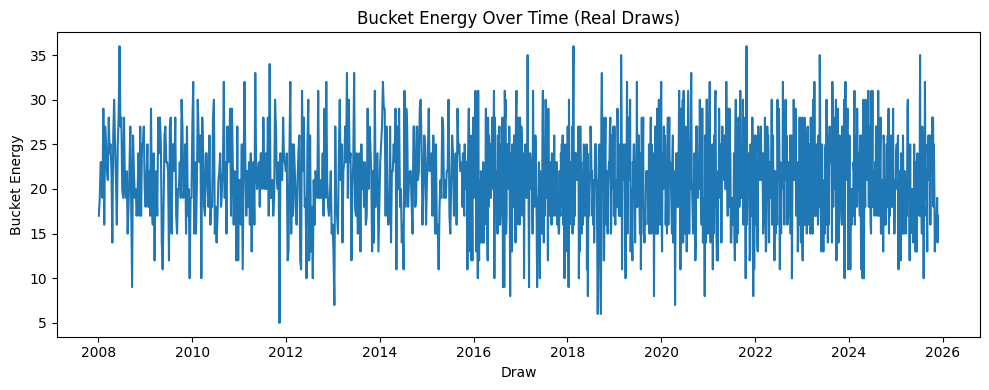

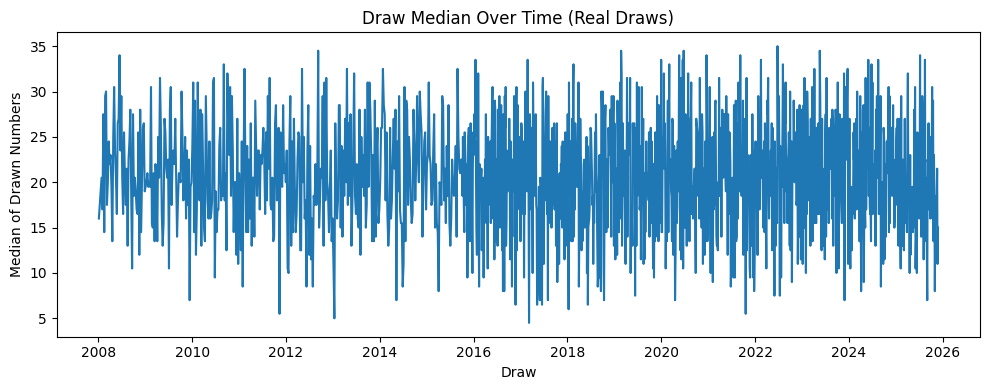

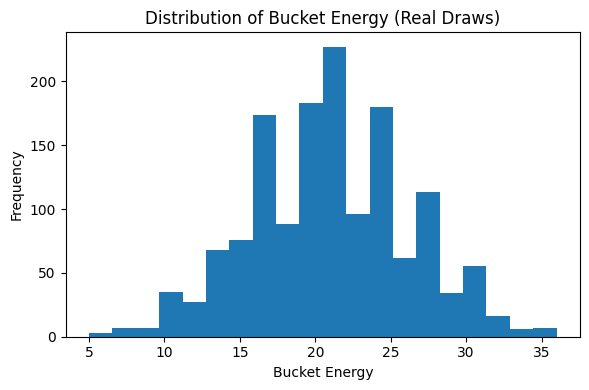

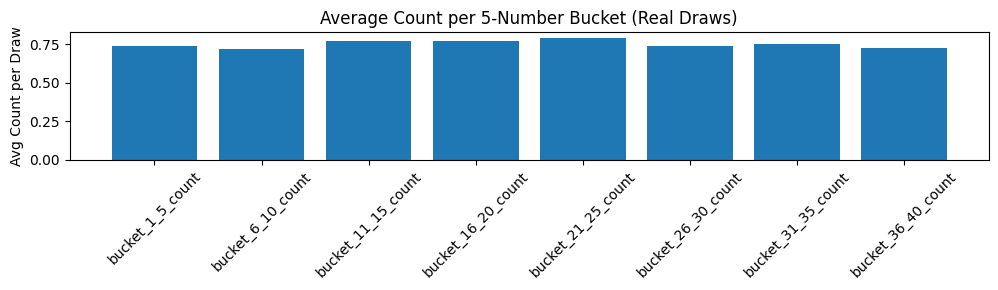

In [18]:
# Visualisations: bucket_energy & draw_median over time, plus distributions
x_axis = df_real_feat["Date"] if "Date" in df_real_feat.columns else df_real_feat.index

plt.figure(figsize=(10, 4))
plt.plot(x_axis, df_real_feat["bucket_energy"])
plt.title("Bucket Energy Over Time (Real Draws)")
plt.xlabel("Draw")
plt.ylabel("Bucket Energy")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_axis, df_real_feat["draw_median"])
plt.title("Draw Median Over Time (Real Draws)")
plt.xlabel("Draw")
plt.ylabel("Median of Drawn Numbers")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(df_real_feat["bucket_energy"], bins=20)
plt.title("Distribution of Bucket Energy (Real Draws)")
plt.xlabel("Bucket Energy")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

avg_counts = df_real_feat[bucket_count_cols].mean()
plt.figure(figsize=(10, 3))
plt.bar(range(len(avg_counts)), avg_counts.values)
plt.xticks(range(len(avg_counts)), avg_counts.index, rotation=45)
plt.title("Average Count per 5-Number Bucket (Real Draws)")
plt.ylabel("Avg Count per Draw")
plt.tight_layout()
plt.show()

In [19]:
# Empirical distribution of numbers from real draws
def compute_empirical_probs(df_base: pd.DataFrame, number_columns) -> pd.Series:
    nums = df_base[number_columns].values.ravel()
    values, counts = np.unique(nums, return_counts=True)
    n_min = int(nums.min())
    n_max = int(nums.max())
    all_numbers = np.arange(n_min, n_max + 1)

    freq = pd.Series(0, index=all_numbers, dtype=float)
    freq.loc[values] = counts
    p_emp = freq / freq.sum()
    return p_emp

p_empirical = compute_empirical_probs(df_draws, number_cols)
p_uniform = pd.Series(1.0 / len(p_empirical), index=p_empirical.index, dtype=float)

# Blend empirical with uniform so we expand the observed pattern distribution
alpha = 0.7  # 70% empirical, 30% uniform
p_blended = alpha * p_empirical + (1 - alpha) * p_uniform
p_blended = p_blended / p_blended.sum()

print("First few blended probabilities:")
print(p_blended.head())

def simulate_single_draw(draw_size=6, probs: pd.Series = p_blended):
    """Simulate one lotto draw by sampling without replacement from the blended distribution."""
    numbers = probs.index.to_numpy()
    p = probs.values
    sample = np.random.choice(numbers, size=draw_size, replace=False, p=p)
    return np.sort(sample)

def simulate_dataset(n_draws=100_000, draw_size=6, probs: pd.Series = p_blended):
    draws = [simulate_single_draw(draw_size, probs) for _ in range(n_draws)]
    df_sim = pd.DataFrame(draws, columns=number_cols[:draw_size])
    df_sim["SimDrawID"] = np.arange(1, n_draws + 1)
    # Synthetic dates purely for plotting/ordering
    df_sim["SimDate"] = pd.date_range("2000-01-01", periods=n_draws, freq="D")
    return df_sim

N_SYNTH_DRAWS = 50_000  # adjust as you like
df_synth = simulate_dataset(N_SYNTH_DRAWS)
print("Synthetic draws shape:", df_synth.shape)
df_synth.head()

First few blended probabilities:
1    0.026068
2    0.024713
3    0.023996
4    0.024474
5    0.024633
dtype: float64
Synthetic draws shape: (50000, 8)


,Winning Number 1,2,3,4,5,6,SimDrawID,SimDate
0,2,4,8,13,22,34,1,2000-01-01
1,1,10,21,24,26,27,2,2000-01-02
2,6,8,14,16,28,38,3,2000-01-03
3,5,11,27,33,35,37,4,2000-01-04
4,4,10,22,23,27,36,5,2000-01-05


Average bucket counts (real):
bucket_1_5_count      0.740
bucket_6_10_count     0.717
bucket_11_15_count    0.769
bucket_16_20_count    0.770
bucket_21_25_count    0.788
bucket_26_30_count    0.738
bucket_31_35_count    0.753
bucket_36_40_count    0.725
dtype: float64

Average bucket counts (synthetic):
bucket_1_5_count      0.744
bucket_6_10_count     0.730
bucket_11_15_count    0.759
bucket_16_20_count    0.760
bucket_21_25_count    0.774
bucket_26_30_count    0.746
bucket_31_35_count    0.753
bucket_36_40_count    0.733
dtype: float64


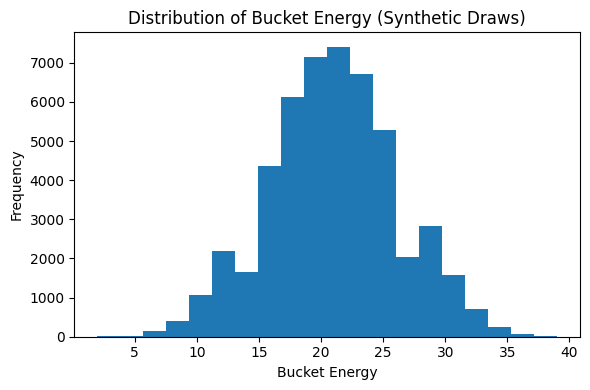

In [20]:
# Compute the same bucket features for synthetic draws
df_synth_feat = compute_bucket_features_for_draws(df_synth)

print("Average bucket counts (real):")
print(df_real_feat[bucket_count_cols].mean().round(3))

print("\nAverage bucket counts (synthetic):")
print(df_synth_feat[bucket_count_cols].mean().round(3))

# Optional: synthetic bucket energy distribution
plt.figure(figsize=(6, 4))
plt.hist(df_synth_feat["bucket_energy"], bins=20)
plt.title("Distribution of Bucket Energy (Synthetic Draws)")
plt.xlabel("Bucket Energy")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Delta Export, Monte Carlo-Augmented Training, and Lotto Number Generation

In [21]:
from pathlib import Path

# Delta Lake export for real + synthetic feature tables
try:
    from deltalake import write_deltalake
    import pyarrow as pa
    HAS_DELTALAKE = True
except ImportError:
    HAS_DELTALAKE = False
    print("Warning: 'deltalake' or 'pyarrow' not installed; skipping Delta writes.")
    print("Install with: pip install deltalake pyarrow")

delta_base = Path("delta_lotto")
delta_base.mkdir(parents=True, exist_ok=True)

if HAS_DELTALAKE:
    real_delta_path = delta_base / "real_features"
    synth_delta_path = delta_base / "synthetic_features"

    # Convert pandas DataFrames to Arrow tables explicitly
    real_table = pa.Table.from_pandas(df_real_feat, preserve_index=False)
    synth_table = pa.Table.from_pandas(df_synth_feat, preserve_index=False)

    print(f"Writing real feature table to Delta: {real_delta_path}")
    write_deltalake(str(real_delta_path), real_table, mode="overwrite")

    print(f"Writing synthetic feature table to Delta: {synth_delta_path}")
    write_deltalake(str(synth_delta_path), synth_table, mode="overwrite")

    print("Delta export complete.")
else:
    print("Delta export skipped.")

Writing real feature table to Delta: delta_lotto/real_features
Writing synthetic feature table to Delta: delta_lotto/synthetic_features
Delta export complete.


In [22]:
# Retrain XGBoost on augmented dataset: real + synthetic Monte Carlo draws
# We reuse:
# - feature_cols: feature column list used originally
# - target_cols: the six winning-number columns
# - model: the Pipeline(imputer + MultiOutputRegressor(XGBRegressor))

# Ensure we have the target columns present in both real and synthetic feature tables
missing_targets_real = [c for c in target_cols if c not in df_real_feat.columns]
missing_targets_synth = [c for c in target_cols if c not in df_synth_feat.columns]

if missing_targets_real or missing_targets_synth:
    print("Warning: some target columns are missing in real or synthetic tables.")
    print("Missing in real:", missing_targets_real)
    print("Missing in synthetic:", missing_targets_synth)
else:
    # Build augmented dataframe with just the columns we need
    cols_needed = feature_cols + target_cols

    # Ensure synthetic feature table has all required columns; fill missing with 0
    for col in cols_needed:
        if col not in df_synth_feat.columns:
            df_synth_feat[col] = 0

    # Also ensure real feature table has all required columns (defensive)
    for col in cols_needed:
        if col not in df_real_feat.columns:
            df_real_feat[col] = 0

    df_real_aug = df_real_feat[cols_needed].copy()
    df_synth_aug = df_synth_feat[cols_needed].copy()

    df_aug = pd.concat([df_real_aug, df_synth_aug], axis=0, ignore_index=True)
    print("Augmented dataset shape:", df_aug.shape)

    X_aug = df_aug[feature_cols].values
    y_aug = df_aug[target_cols].values

    print("Augmented feature matrix shape:", X_aug.shape)
    print("Augmented target matrix shape:", y_aug.shape)

    # Fit a new model on the full augmented dataset (no extra CV here)
    model_mc = model.fit(X_aug, y_aug)
    print("Monte Carlo-augmented XGBoost model trained and stored as 'model_mc'.")

Augmented dataset shape: (51464, 29)
Augmented feature matrix shape: (51464, 23)
Augmented target matrix shape: (51464, 6)
Monte Carlo-augmented XGBoost model trained and stored as 'model_mc'.


In [23]:
# Generate example Lotto predictions using the current model (prefers model_mc if available)
num_predictions = 5
for i in range(num_predictions):
    candidate_numbers = np.sort(np.random.choice(np.arange(1, 41), size=6, replace=False))
    input_df = build_features_from_draw(candidate_numbers, feature_cols)

    if "model_mc" in globals():
        pred = model_mc.predict(input_df.values)[0]
        model_used = "model_mc (augmented)"
    else:
        pred = best_model.predict(input_df.values)[0]
        model_used = "best_model (original CV best)"

    predicted_numbers = sanitize_prediction(pred, n_numbers=6, low=1, high=40)

    print(f"Prediction set {i+1} using {model_used}:")
    print("  Candidate base numbers:", candidate_numbers)
    print("  Model predicted numbers:", predicted_numbers)
    print("-" * 60)

Prediction set 1 using model_mc (augmented):
  Candidate base numbers: [ 4  5 16 17 29 35]
  Model predicted numbers: [ 2  4 17 20 27 33]
------------------------------------------------------------
Prediction set 2 using model_mc (augmented):
  Candidate base numbers: [ 6 24 29 31 33 37]
  Model predicted numbers: [ 8 23 28 32 34 38]
------------------------------------------------------------
Prediction set 3 using model_mc (augmented):
  Candidate base numbers: [ 7 21 23 24 29 30]
  Model predicted numbers: [ 8 19 25 27 29 37]
------------------------------------------------------------
Prediction set 4 using model_mc (augmented):
  Candidate base numbers: [ 7  8 11 25 33 38]
  Model predicted numbers: [ 7  9 14 22 33 38]
------------------------------------------------------------
Prediction set 5 using model_mc (augmented):
  Candidate base numbers: [17 18 25 30 31 37]
  Model predicted numbers: [17 19 22 28 33 38]
------------------------------------------------------------


## Pattern Resonance Scoring & Extra Visualisations

This section adds:
- A **pattern resonance score** for any predicted Lotto line, comparing it to historical draw structure.
- Extra plots comparing **real vs synthetic** distributions and highlighting where model-generated lines sit in feature space.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Pattern resonance helpers ---

def line_to_features(line_numbers, max_bucket_local=None, bucket_size_local=5):
    """Compute a feature dict for a single line of numbers:

    - bucket_counts (per 5-number bucket)
    - bucket_energy
    - draw_median
    - Odd / Even counts
    - mean_gap / median_gap / std_gap between sorted numbers
    - decade_transitions across 10-number bands (1–10, 11–20, ...)
    - gap_entropy (normalized entropy of the gap distribution)
    """
    line_numbers = np.array(line_numbers, dtype=int)
    if max_bucket_local is None:
        max_bucket_local = max_bucket

    # bucket counts
    counts = np.zeros(max_bucket_local + 1, dtype=int)
    for n in line_numbers:
        b = num_to_bucket(n, bucket_size=bucket_size_local)
        if 0 <= b <= max_bucket_local:
            counts[b] += 1

    feats = {}
    feats["bucket_counts"] = counts
    feats["bucket_energy"] = sum(i * counts[i] for i in range(max_bucket_local + 1))
    feats["draw_median"] = float(np.median(line_numbers))
    feats["Odd"] = int((line_numbers % 2 != 0).sum())
    feats["Even"] = int((line_numbers % 2 == 0).sum())

    # Gap-based features
    line_sorted = np.sort(line_numbers)
    if len(line_sorted) > 1:
        gaps = np.diff(line_sorted.astype(float))
    else:
        gaps = np.array([0.0])

    feats["mean_gap"] = float(np.mean(gaps))
    feats["median_gap"] = float(np.median(gaps))
    feats["std_gap"] = float(np.std(gaps, ddof=0))

    # Decade transitions: 1–10 -> 0, 11–20 -> 1, etc.
    decades = ((line_sorted - 1) // 10).astype(int)
    if len(decades) > 1:
        feats["decade_transitions"] = float(np.count_nonzero(np.diff(decades) != 0))
    else:
        feats["decade_transitions"] = 0.0

    # Gap entropy (normalized)
    if len(gaps) > 0:
        uniq, counts_g = np.unique(gaps, return_counts=True)
        probs = counts_g.astype(float) / counts_g.sum()
        ent = -np.sum(probs * np.log(probs))
        if len(probs) > 1:
            feats["gap_entropy"] = float(ent / np.log(len(probs)))
        else:
            feats["gap_entropy"] = 0.0
    else:
        feats["gap_entropy"] = 0.0

    return feats


def compute_historical_profiles(df_real_feat, bucket_count_cols):
    """Precompute historical reference statistics from real draws."""
    hist = {}
    # Average bucket counts per draw
    hist["mean_bucket_counts"] = df_real_feat[bucket_count_cols].mean().values
    hist["std_bucket_counts"] = df_real_feat[bucket_count_cols].std(ddof=0).values

    # bucket_energy stats
    hist["mean_bucket_energy"] = df_real_feat["bucket_energy"].mean()
    hist["std_bucket_energy"] = df_real_feat["bucket_energy"].std(ddof=0)

    # draw_median stats (if present)
    if "draw_median" in df_real_feat.columns:
        hist["mean_draw_median"] = df_real_feat["draw_median"].mean()
        hist["std_draw_median"] = df_real_feat["draw_median"].std(ddof=0)
    else:
        hist["mean_draw_median"] = None
        hist["std_draw_median"] = None

    # Odd/Even stats if available
    if "Odd" in df_real_feat.columns and "Even" in df_real_feat.columns:
        hist["mean_odd"] = df_real_feat["Odd"].mean()
        hist["mean_even"] = df_real_feat["Even"].mean()
    else:
        hist["mean_odd"] = None
        hist["mean_even"] = None

    # Gap / decade / entropy stats if available
    for col in ["mean_gap", "median_gap", "std_gap", "decade_transitions", "gap_entropy"]:
        if col in df_real_feat.columns:
            hist[f"mean_{col}"] = df_real_feat[col].mean()
            hist[f"std_{col}"] = df_real_feat[col].std(ddof=0)
        else:
            hist[f"mean_{col}"] = None
            hist[f"std_{col}"] = None

    return hist


def pattern_resonance_score(line_numbers, hist_profile, bucket_count_cols):
    """Compute a 0–1 'pattern resonance' score indicating how Lotto-like
    a given line is, compared to historical patterns.

    Uses:
    - Bucket count distance
    - Bucket energy distance (z-score)
    - Median distance (z-score)
    - Odd/even balance
    - Gap structure similarity (mean_gap, std_gap)
    - Decade transition similarity
    - Gap entropy similarity
    """
    feats = line_to_features(line_numbers)
    counts = feats["bucket_counts"].astype(float)

    # --- Bucket count score (Euclidean distance vs mean, normalized) ---
    mean_counts = hist_profile["mean_bucket_counts"]
    std_counts = hist_profile["std_bucket_counts"]
    if std_counts is not None:
        diff = (counts - mean_counts) / (std_counts + 1e-6)
        dist = np.linalg.norm(diff)
        bucket_score = np.exp(-dist / (2.0 * len(counts) ** 0.5))
    else:
        bucket_score = 1.0

    # --- Bucket energy score ---
    if hist_profile["std_bucket_energy"] not in (None, 0):
        z_energy = (feats["bucket_energy"] - hist_profile["mean_bucket_energy"]) / hist_profile["std_bucket_energy"]
        energy_score = np.exp(-abs(z_energy))
    else:
        energy_score = 1.0

    # --- Median score ---
    if hist_profile["mean_draw_median"] is not None and hist_profile["std_draw_median"] not in (None, 0):
        z_median = (feats["draw_median"] - hist_profile["mean_draw_median"]) / hist_profile["std_draw_median"]
        median_score = np.exp(-abs(z_median))
    else:
        median_score = 1.0

    # --- Odd/Even score ---
    if hist_profile["mean_odd"] is not None and hist_profile["mean_even"] is not None:
        odd_diff = abs(feats["Odd"] - hist_profile["mean_odd"])
        even_diff = abs(feats["Even"] - hist_profile["mean_even"])
        # Assume typical odd/even deviations of ~1.5 are fine
        odd_even_score = np.exp(-(odd_diff + even_diff) / 3.0)
    else:
        odd_even_score = 1.0

    # --- Gap structure score (mean_gap, std_gap) ---
    gap_scores = []
    for col in ["mean_gap", "std_gap"]:
        mean_key = f"mean_{col}"
        std_key = f"std_{col}"
        if hist_profile.get(mean_key) is not None and hist_profile.get(std_key) not in (None, 0):
            z = (feats[col] - hist_profile[mean_key]) / hist_profile[std_key]
            gap_scores.append(np.exp(-abs(z)))
    if gap_scores:
        gap_score = float(np.prod(gap_scores) ** (1.0 / len(gap_scores)))
    else:
        gap_score = 1.0

    # --- Decade transition score ---
    mean_dec = hist_profile.get("mean_decade_transitions")
    std_dec = hist_profile.get("std_decade_transitions")
    if mean_dec is not None and std_dec not in (None, 0):
        z_dec = (feats["decade_transitions"] - mean_dec) / std_dec
        decade_score = float(np.exp(-abs(z_dec)))
    else:
        decade_score = 1.0

    # --- Gap entropy score ---
    mean_ge = hist_profile.get("mean_gap_entropy")
    std_ge = hist_profile.get("std_gap_entropy")
    if mean_ge is not None and std_ge not in (None, 0):
        z_ge = (feats["gap_entropy"] - mean_ge) / std_ge
        entropy_score = float(np.exp(-abs(z_ge)))
    else:
        entropy_score = 1.0

    # Combine scores (geometric mean for balance)
    scores = np.array([bucket_score, energy_score, median_score, odd_even_score,
                       gap_score, decade_score, entropy_score])
    pattern_score = float(np.prod(scores) ** (1.0 / len(scores)))
    return pattern_score, {
        "bucket_score": float(bucket_score),
        "energy_score": float(energy_score),
        "median_score": float(median_score),
        "odd_even_score": float(odd_even_score),
        "gap_score": float(gap_score),
        "decade_score": float(decade_score),
        "entropy_score": float(entropy_score),
    }


# Precompute historical profile once, if not already done
historical_profile = compute_historical_profiles(df_real_feat, bucket_count_cols)
print("Historical pattern profile computed (extended with gap/decade stats)." )

Historical pattern profile computed (extended with gap/decade stats).


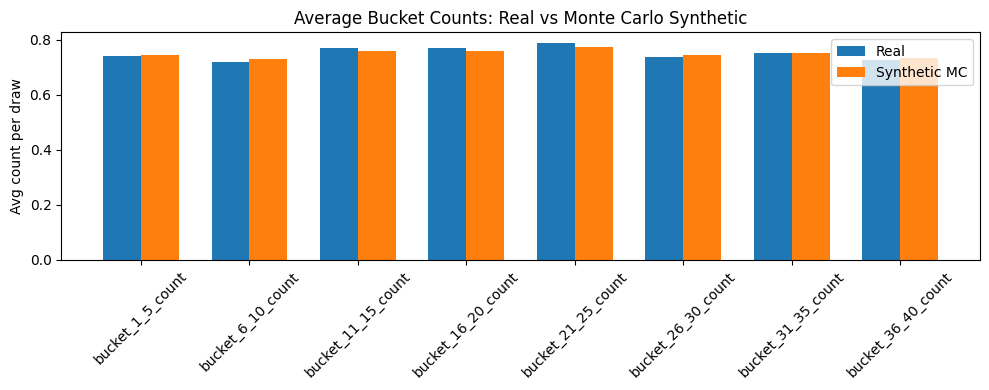

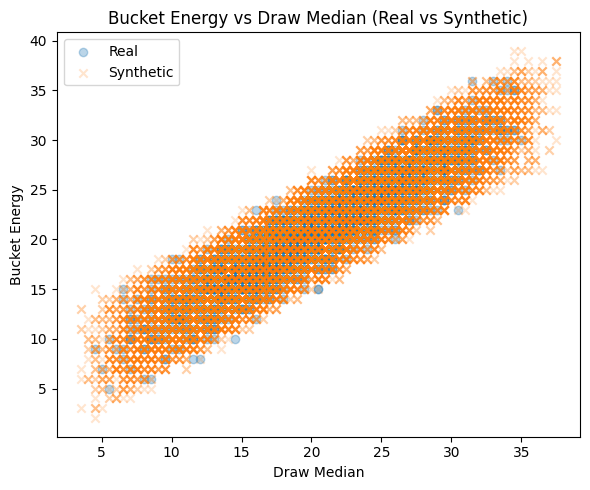

Example pattern resonance scores:
Line [3, 8, 16, 20, 23, 28] -> score=0.539, components={'bucket_score': 0.6492959945202568, 'energy_score': 0.38690511367946734, 'median_score': 0.6582811923068332, 'odd_even_score': 0.508067861340666, 'gap_score': 0.348944186378886, 'decade_score': 0.5369300100710211, 'entropy_score': 0.8450371591227578}
Line [3, 12, 18, 26, 29, 33] -> score=0.646, components={'bucket_score': 0.6450203465744617, 'energy_score': 0.9996107458076535, 'median_score': 0.784258921902531, 'odd_even_score': 0.9895810686990621, 'gap_score': 0.5383035908323629, 'decade_score': 0.35898172613616564, 'entropy_score': 0.4880562002465512}
Line [2, 4, 8, 13, 18, 33] -> score=0.451, components={'bucket_score': 0.6486355705001252, 'energy_score': 0.18094757970950018, 'median_score': 0.19056555889161778, 'odd_even_score': 0.508067861340666, 'gap_score': 0.7410678120359806, 'decade_score': 0.5369300100710211, 'entropy_score': 0.8450371591227578}
Line [8, 16, 19, 23, 33, 38] -> score=0.62

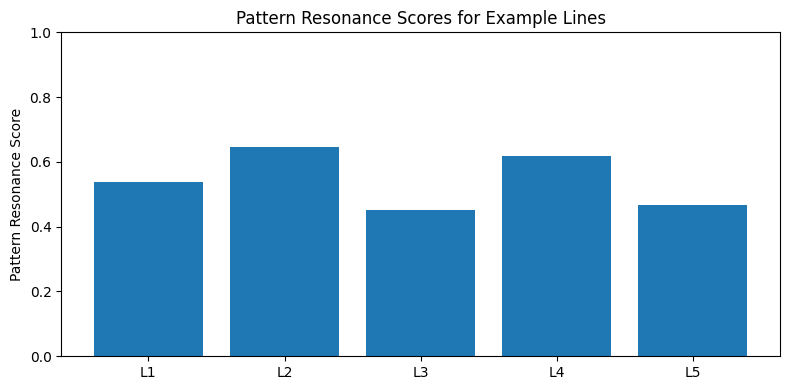

In [25]:

# --- Extra visualisations ---

# 1) Real vs synthetic average bucket counts
if "df_synth_feat" in globals():
    real_avg_counts = df_real_feat[bucket_count_cols].mean()
    synth_avg_counts = df_synth_feat[bucket_count_cols].mean()

    x = np.arange(len(bucket_count_cols))
    width = 0.35

    plt.figure(figsize=(10, 4))
    plt.bar(x - width/2, real_avg_counts.values, width, label="Real")
    plt.bar(x + width/2, synth_avg_counts.values, width, label="Synthetic MC")
    plt.xticks(x, bucket_count_cols, rotation=45)
    plt.ylabel("Avg count per draw")
    plt.title("Average Bucket Counts: Real vs Monte Carlo Synthetic")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 2) Bucket energy vs median: real vs synthetic
plt.figure(figsize=(6, 5))
if "draw_median" in df_real_feat.columns:
    plt.scatter(df_real_feat["draw_median"], df_real_feat["bucket_energy"], alpha=0.3, label="Real")
    if "df_synth_feat" in globals() and "draw_median" in df_synth_feat.columns:
        plt.scatter(df_synth_feat["draw_median"], df_synth_feat["bucket_energy"], alpha=0.2, label="Synthetic", marker="x")
    plt.xlabel("Draw Median")
    plt.ylabel("Bucket Energy")
    plt.title("Bucket Energy vs Draw Median (Real vs Synthetic)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# 3) Example: score and visualise the last N generated prediction lines
example_lines = [
    np.array([3, 8, 16, 20, 23, 28]),
    np.array([3, 12, 18, 26, 29, 33]),
    np.array([2, 4, 8, 13, 18, 33]),
    np.array([8, 16, 19, 23, 33, 38]),
    np.array([3, 6, 9, 19, 37, 39]),
]

scores = []
for line in example_lines:
    s, breakdown = pattern_resonance_score(line, historical_profile, bucket_count_cols)
    scores.append((line, s, breakdown))

print("Example pattern resonance scores:")
for line, s, breakdown in scores:
    print(f"Line {line.tolist()} -> score={s:.3f}, components={breakdown}")

# Bar plot of overall scores
plt.figure(figsize=(8, 4))
labels = [f"L{i+1}" for i in range(len(scores))]
vals = [s for (_, s, _) in scores]
plt.bar(labels, vals)
plt.ylim(0, 1.0)
plt.ylabel("Pattern Resonance Score")
plt.title("Pattern Resonance Scores for Example Lines")
plt.tight_layout()
plt.show()


## Bulk Generation & Top-N Pattern-Resonant Predictions

This section:
- Generates a large number of model-based Lotto lines (e.g. 10,000)
- Computes the pattern resonance score for each line
- Sorts them and shows the top-N most Lotto-like lines according to historical structure.


In [26]:
import numpy as np
import pandas as pd

def generate_model_line(feature_cols, use_model_mc=True):
    """Generate a single Lotto line using the current model and sanitiser."""
    candidate_numbers = np.sort(np.random.choice(np.arange(1, 41), size=6, replace=False))
    input_df = build_features_from_draw(candidate_numbers, feature_cols)

    # Decide how to predict this line:
    # - If both models exist and use_model_mc=True, use ensemble (real + augmented)
    # - If only model_mc exists and use_model_mc=True, use augmented model
    # - Otherwise, fall back to best_model (real-only)
    if "best_model" in globals() and "model_mc" in globals():
        if use_model_mc:
            if "ENSEMBLE_WEIGHTS" in globals():
                w_base, w_aug = ENSEMBLE_WEIGHTS
            else:
                w_base, w_aug = 0.3, 0.7
            pred_base = best_model.predict(input_df.values)[0]
            pred_aug = model_mc.predict(input_df.values)[0]
            pred = w_base * pred_base + w_aug * pred_aug
        else:
            pred = best_model.predict(input_df.values)[0]
    elif use_model_mc and "model_mc" in globals():
        pred = model_mc.predict(input_df.values)[0]
    else:
        pred = best_model.predict(input_df.values)[0]
    line = sanitize_prediction(pred, n_numbers=6, low=1, high=40)
    return line


def bulk_generate_and_score(
    n_samples=10000,
    top_n=20,
    use_model_mc=True,
    verbose_every=1000
):
    """Generate many model-based Lotto lines, score them, and return Top-N
    UNIQUE lines sorted by pattern resonance and frequency.
    """
    records = []

    for i in range(n_samples):
        # Generate one Lotto line using the ML model
        line = generate_model_line(feature_cols, use_model_mc=use_model_mc)

        # Score pattern resonance
        score, breakdown = pattern_resonance_score(line, historical_profile, bucket_count_cols)

        records.append({
            "line": line,
            "score": score,
            "bucket_score": breakdown["bucket_score"],
            "energy_score": breakdown["energy_score"],
            "median_score": breakdown["median_score"],
            "odd_even_score": breakdown["odd_even_score"],
        })

        if verbose_every and (i + 1) % verbose_every == 0:
            print(f"Generated and scored {i+1} lines...")

    df_scores = pd.DataFrame(records)

    # Make a dedupe key: "3,8,16,20,23,28"
    df_scores["line_str"] = df_scores["line"].apply(lambda arr: ",".join(map(str, arr)))

    # Aggregate unique line stats
    grouped = (
        df_scores
        .groupby("line_str")
        .agg(
            line=("line", "first"),
            score=("score", "max"),
            bucket_score=("bucket_score", "max"),
            energy_score=("energy_score", "max"),
            median_score=("median_score", "max"),
            odd_even_score=("odd_even_score", "max"),
            frequency=("line_str", "count"),
        )
        .reset_index(drop=True)
    )

    # Sort by score desc, then frequency desc
    df_sorted = grouped.sort_values(
        by=["score", "frequency"],
        ascending=[False, False]
    ).reset_index(drop=True)

    print(f"\nTop {top_n} UNIQUE pattern-resonant lines out of {n_samples} samples:\n")

    for idx in range(min(top_n, len(df_sorted))):
        row = df_sorted.iloc[idx]
        print(
            f"Rank {idx+1}: line={row['line'].tolist()}  "
            f"score={row['score']:.3f}  freq={row['frequency']}  "
            f"(bucket={row['bucket_score']:.3f}, "
            f"energy={row['energy_score']:.3f}, "
            f"median={row['median_score']:.3f}, "
            f"odd_even={row['odd_even_score']:.3f})"
        )

    return df_sorted

In [27]:
df_topk = bulk_generate_and_score(
    n_samples=5000,
    top_n=20,
    use_model_mc=True,
    verbose_every=1000
)

Generated and scored 1000 lines...
Generated and scored 2000 lines...
Generated and scored 3000 lines...
Generated and scored 4000 lines...
Generated and scored 5000 lines...

Top 20 UNIQUE pattern-resonant lines out of 5000 samples:

Rank 1: line=[7, 10, 16, 19, 33, 38]  score=0.749  freq=3  (bucket=0.576, energy=1.000, median=0.606, odd_even=0.990)
Rank 2: line=[2, 17, 20, 22, 27, 29]  score=0.748  freq=2  (bucket=0.580, energy=0.827, median=0.925, odd_even=0.990)
Rank 3: line=[3, 13, 18, 23, 32, 34]  score=0.735  freq=8  (bucket=0.648, energy=1.000, median=0.995, odd_even=0.990)
Rank 4: line=[7, 9, 18, 23, 28, 38]  score=0.734  freq=9  (bucket=0.640, energy=1.000, median=0.995, odd_even=0.990)
Rank 5: line=[2, 8, 21, 25, 31, 34]  score=0.733  freq=5  (bucket=0.581, energy=1.000, median=0.665, odd_even=0.990)
Rank 6: line=[7, 9, 18, 23, 32, 34]  score=0.727  freq=4  (bucket=0.574, energy=1.000, median=0.995, odd_even=0.990)
Rank 7: line=[2, 17, 20, 21, 25, 28]  score=0.726  freq=1  (

## Extra Analysis of Top Pattern-Resonant Lines

These plots help understand how the top-ranked lines relate to historical structure:
- Histogram of resonance scores for the unique top lines
- Resonance vs line median
- Resonance vs bucket energy


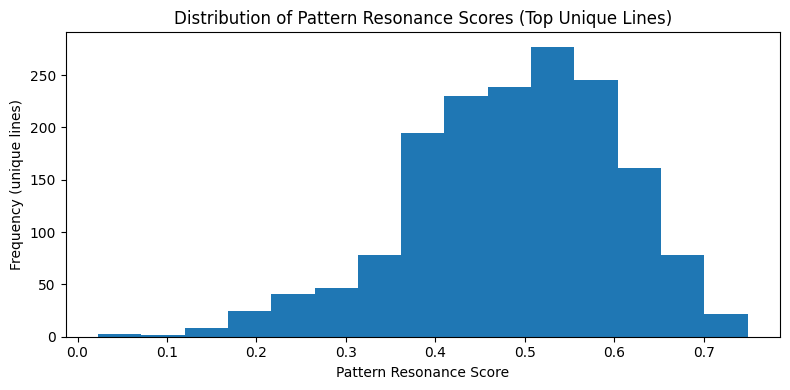

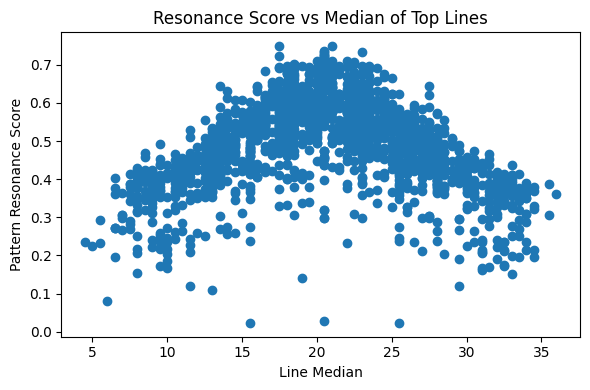

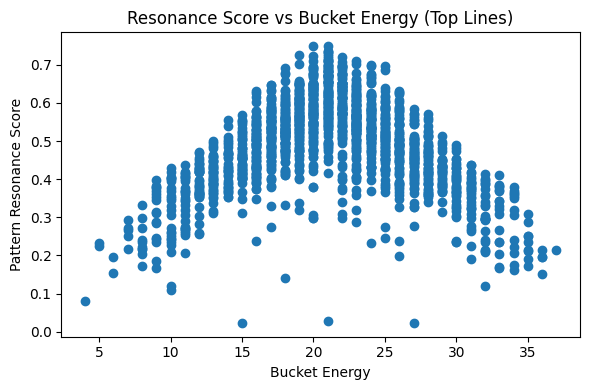

In [28]:

import matplotlib.pyplot as plt
import numpy as np

# Ensure df_topk exists
if 'df_topk' in globals() and not df_topk.empty:
    # 1) Histogram of resonance scores
    plt.figure(figsize=(8, 4))
    plt.hist(df_topk["score"], bins=15)
    plt.xlabel("Pattern Resonance Score")
    plt.ylabel("Frequency (unique lines)")
    plt.title("Distribution of Pattern Resonance Scores (Top Unique Lines)")
    plt.tight_layout()
    plt.show()

    # 2) Score vs median for each top line
    medians = []
    scores = df_topk["score"].values

    for line in df_topk["line"]:
        line_arr = np.array(line, dtype=int)
        medians.append(np.median(line_arr))

    medians = np.array(medians)

    plt.figure(figsize=(6, 4))
    plt.scatter(medians, scores)
    plt.xlabel("Line Median")
    plt.ylabel("Pattern Resonance Score")
    plt.title("Resonance Score vs Median of Top Lines")
    plt.tight_layout()
    plt.show()

    # 3) Score vs bucket energy for each top line
    energies = []
    for line in df_topk["line"]:
        feats = line_to_features(line)
        energies.append(feats["bucket_energy"])

    energies = np.array(energies)

    plt.figure(figsize=(6, 4))
    plt.scatter(energies, scores)
    plt.xlabel("Bucket Energy")
    plt.ylabel("Pattern Resonance Score")
    plt.title("Resonance Score vs Bucket Energy (Top Lines)")
    plt.tight_layout()
    plt.show()
else:
    print("df_topk is not defined or is empty. Run bulk_generate_and_score first.")


## Advanced Pattern Space Visualisations & Final Picks

This section adds:
- A 3D-style view of pattern space: resonance vs median vs bucket energy
- Number frequency analysis across the top-K lines
- Bucket heatmap for top-K lines
- A simple grouped printout of final picks:
  - Stable high-resonance patterns
  - Mid-resonance variants
  - Wildcard lines


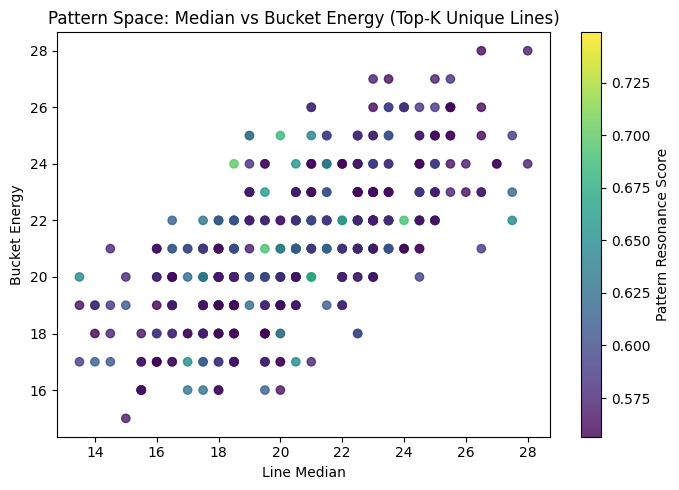

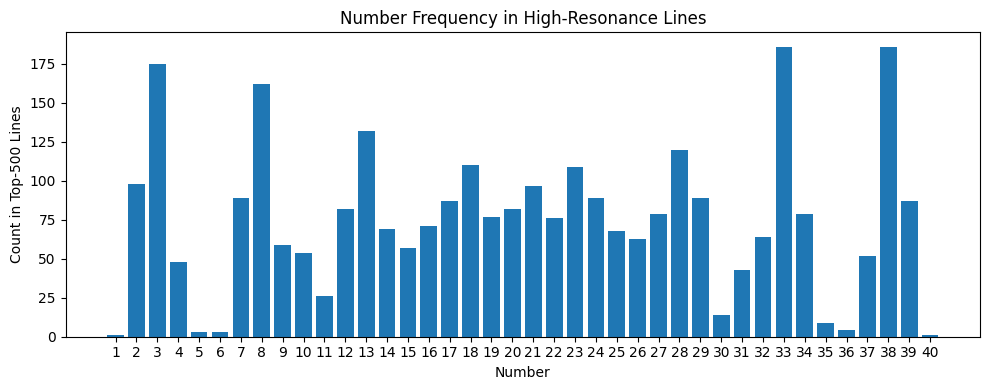

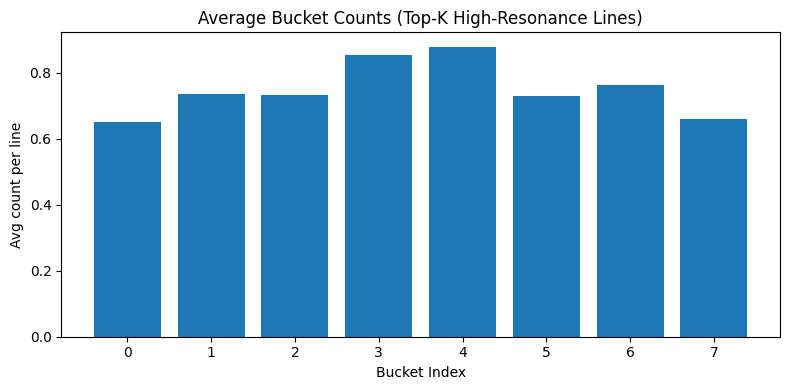


=== Final Picks Summary ===

>> Stable High-Resonance Patterns (Top 10):
  Rank 1: line=[7, 10, 16, 19, 33, 38]  score=0.749  freq=3
  Rank 2: line=[2, 17, 20, 22, 27, 29]  score=0.748  freq=2
  Rank 3: line=[3, 13, 18, 23, 32, 34]  score=0.735  freq=8
  Rank 4: line=[7, 9, 18, 23, 28, 38]  score=0.734  freq=9
  Rank 5: line=[2, 8, 21, 25, 31, 34]  score=0.733  freq=5
  Rank 6: line=[7, 9, 18, 23, 32, 34]  score=0.727  freq=4
  Rank 7: line=[2, 17, 20, 21, 25, 28]  score=0.726  freq=1
  Rank 8: line=[2, 12, 15, 26, 29, 33]  score=0.723  freq=5
  Rank 9: line=[3, 13, 16, 19, 32, 38]  score=0.723  freq=1
  Rank 10: line=[13, 16, 20, 21, 24, 35]  score=0.720  freq=1

>> Mid-Resonance Variant Lines (sample slice):
  idx 550: line=[7, 9, 13, 16, 20, 33]  score=0.547  freq=7
  idx 551: line=[2, 9, 18, 31, 34, 38]  score=0.547  freq=8
  idx 552: line=[3, 8, 22, 28, 32, 34]  score=0.547  freq=8
  idx 553: line=[3, 9, 17, 19, 33, 38]  score=0.546  freq=5
  idx 554: line=[8, 21, 25, 28, 32, 34]

In [29]:

import numpy as np
import matplotlib.pyplot as plt

# Use df_topk from bulk_generate_and_score; require it exists
if 'df_topk' not in globals() or df_topk.empty:
    print("df_topk is not defined or empty. Run bulk_generate_and_score first.")
else:
    # Limit to top_K for plots (to avoid clutter)
    top_K = min(500, len(df_topk))
    df_plot = df_topk.iloc[:top_K].copy()

    # --- Compute median and bucket_energy for each top line ---
    medians = []
    energies = []
    scores = df_plot["score"].values

    for line in df_plot["line"]:
        arr = np.array(line, dtype=int)
        feats = line_to_features(arr)
        medians.append(feats["draw_median"])
        energies.append(feats["bucket_energy"])

    medians = np.array(medians)
    energies = np.array(energies)

    # --- 1) 2D "3D-style" scatter: energy vs median, colour = resonance score ---
    plt.figure(figsize=(7, 5))
    sc = plt.scatter(medians, energies, c=scores, alpha=0.8)
    plt.colorbar(sc, label="Pattern Resonance Score")
    plt.xlabel("Line Median")
    plt.ylabel("Bucket Energy")
    plt.title("Pattern Space: Median vs Bucket Energy (Top-K Unique Lines)")
    plt.tight_layout()
    plt.show()

    # --- 2) Number frequency across top-K lines ---
    number_counts = np.zeros(40, dtype=int)  # 1..40
    for line in df_plot["line"]:
        arr = np.array(line, dtype=int)
        for n in arr:
            if 1 <= n <= 40:
                number_counts[n-1] += 1

    plt.figure(figsize=(10, 4))
    plt.bar(np.arange(1, 41), number_counts)
    plt.xlabel("Number")
    plt.ylabel(f"Count in Top-{top_K} Lines")
    plt.title("Number Frequency in High-Resonance Lines")
    plt.xticks(np.arange(1, 41))
    plt.tight_layout()
    plt.show()

    # --- 3) Bucket heatmap for top-K lines ---
    # Rebuild bucket counts for each line
    max_b = max_bucket
    bucket_matrix = np.zeros((top_K, max_b + 1), dtype=int)
    for idx, line in enumerate(df_plot["line"]):
        arr = np.array(line, dtype=int)
        counts = np.zeros(max_b + 1, dtype=int)
        for n in arr:
            b = num_to_bucket(n, bucket_size=5)
            if 0 <= b <= max_b:
                counts[b] += 1
        bucket_matrix[idx, :] = counts

    avg_bucket_counts_top = bucket_matrix.mean(axis=0)

    plt.figure(figsize=(8, 4))
    plt.bar(np.arange(len(avg_bucket_counts_top)), avg_bucket_counts_top)
    plt.xlabel("Bucket Index")
    plt.ylabel("Avg count per line")
    plt.title("Average Bucket Counts (Top-K High-Resonance Lines)")
    plt.xticks(np.arange(len(avg_bucket_counts_top)))
    plt.tight_layout()
    plt.show()

    # --- 4) Final Picks: group lines into categories ---
    print("\n=== Final Picks Summary ===\n")

    # Stable high-resonance patterns: top 10 by score & frequency
    top_stable = df_topk.iloc[:10]
    print(">> Stable High-Resonance Patterns (Top 10):")
    for idx, row in top_stable.iterrows():
        print(f"  Rank {idx+1}: line={row['line'].tolist()}  "
              f"score={row['score']:.3f}  freq={row['frequency']}")

    # Mid-resonance variants: take a slice from the middle of df_topk
    mid_start = len(df_topk) // 3
    mid_end = min(mid_start + 10, len(df_topk))
    mid_slice = df_topk.iloc[mid_start:mid_end]

    print("\n>> Mid-Resonance Variant Lines (sample slice):")
    for idx, row in mid_slice.iterrows():
        print(f"  idx {idx}: line={row['line'].tolist()}  "
              f"score={row['score']:.3f}  freq={row['frequency']}")

    # Wildcard lines: pick 10 random lines from lower half of df_topk
    if len(df_topk) > 20:
        lower_half = df_topk.iloc[len(df_topk)//2:]
        wildcard_sample = lower_half.sample(n=min(10, len(lower_half)), random_state=42)

        print("\n>> Wildcard Lines (random from lower half):")
        for idx, row in wildcard_sample.iterrows():
            print(f"  idx {idx}: line={row['line'].tolist()}  "
                  f"score={row['score']:.3f}  freq={row['frequency']}")
    else:
        print("\nNot enough lines for wildcard sampling; df_topk too small.")


In [30]:
# === Rev13: multi-run resonance stability analysis ===

def multi_run_resonance_stability(
    n_runs=5,
    n_samples_per_run=10000,
    top_n=50,
    use_model_mc=True,
):
    """
    Run bulk_generate_and_score multiple times and analyse how often
    specific lines appear in the top-N across runs.

    Returns a DataFrame with:
      - line_str
      - line (array of 6 ints)
      - max_score
      - mean_score
      - times_seen (in how many runs this line appeared)
    """
    all_frames = []

    for r in range(n_runs):
        print(f"\n=== Resonance run {r+1}/{n_runs} ===")
        df_run = bulk_generate_and_score(
            n_samples=n_samples_per_run,
            top_n=top_n,
            use_model_mc=use_model_mc,
            verbose_every=max(1000, n_samples_per_run // 10),
        )
        df_run = df_run.copy()
        df_run["run_id"] = r
        all_frames.append(df_run[["line_str", "line", "score", "run_id"]])

    if not all_frames:
        print("No runs executed.")
        return None

    df_all = pd.concat(all_frames, axis=0, ignore_index=True)

    stability = (
        df_all
        .groupby("line_str")
        .agg(
            line=("line", "first"),
            max_score=("score", "max"),
            mean_score=("score", "mean"),
            times_seen=("run_id", "nunique"),
        )
        .reset_index()
        .sort_values(["times_seen", "mean_score", "max_score"], ascending=[False, False, False])
    )

    print("\nTop resonance-stable lines across runs:\n")
    print(stability.head(20))

    return stability

In [31]:

# === Rev14: simple Genetic Algorithm search on pattern resonance ===

import random

def random_line():
    return tuple(sorted(random.sample(range(1, 41), 6)))

def mutate_line(line):
    line = list(line)
    if random.random() < 0.5:
        # replace one number
        idx = random.randrange(6)
        new_val = random.randint(1, 40)
        while new_val in line:
            new_val = random.randint(1, 40)
        line[idx] = new_val
    else:
        # small +/- mutation on one position
        idx = random.randrange(6)
        delta = random.choice([-3, -2, -1, 1, 2, 3])
        new_val = min(40, max(1, line[idx] + delta))
        line[idx] = new_val
    return tuple(sorted(line))

def crossover_lines(a, b):
    # single-point crossover
    a = list(a)
    b = list(b)
    point = random.randint(1, 5)
    child = sorted(a[:point] + b[point:])
    # ensure uniqueness
    child = list(dict.fromkeys(child))  # remove duplicates preserving order
    while len(child) < 6:
        v = random.randint(1, 40)
        if v not in child:
            child.append(v)
    if len(child) > 6:
        child = child[:6]
    return tuple(sorted(child))

def line_fitness(line):
    # Use pattern_resonance_score as the primary fitness
    score, _ = pattern_resonance_score(line, historical_profile, bucket_count_cols)
    return score

def genetic_search(
    pop_size=120,
    num_generations=40,
    mutation_rate=0.12,
    crossover_rate=0.85,
):
    """Run a simple GA over the space of Lotto lines to maximise pattern resonance."""
    # Initial population
    population = [random_line() for _ in range(pop_size)]

    def evaluate_pop(pop):
        fit = []
        for ln in pop:
            fit.append(line_fitness(ln))
        return fit

    fitness = evaluate_pop(population)

    for gen in range(num_generations):
        # Selection (tournament)
        new_pop = []
        while len(new_pop) < pop_size:
            # tournament select parents
            i1, i2 = random.randrange(pop_size), random.randrange(pop_size)
            p1 = population[i1] if fitness[i1] >= fitness[i2] else population[i2]

            i3, i4 = random.randrange(pop_size), random.randrange(pop_size)
            p2 = population[i3] if fitness[i3] >= fitness[i4] else population[i4]

            # Crossover
            if random.random() < crossover_rate:
                child = crossover_lines(p1, p2)
            else:
                child = p1

            # Mutation
            if random.random() < mutation_rate:
                child = mutate_line(child)

            new_pop.append(child)

        population = new_pop
        fitness = evaluate_pop(population)

        if (gen + 1) % max(1, num_generations // 5) == 0:
            best_idx = max(range(pop_size), key=lambda i: fitness[i])
            print(f"Generation {gen+1}/{num_generations} -> best score={fitness[best_idx]:.3f}, line={population[best_idx]}")

    # Final ranking
    results = list(zip(population, fitness))
    results.sort(key=lambda x: x[1], reverse=True)

    print("\nTop 20 GA lines by pattern resonance:")
    for rank, (ln, sc) in enumerate(results[:20], start=1):
        print(f"  Rank {rank}: line={list(ln)}  score={sc:.3f}")

    return results


In [32]:

# === Rev15: convergence analysis over historical draws (batched, accelerated) ===
# Estimate how many model-generated lines are needed to "hit" the actual draw.
# Uses generate_model_line + (optionally) GPU-accelerated models.

import math

# Configuration: you can tweak these depending on how heavy you want the run to be.
CONV_MAX_ITER_PER_DRAW = 20000   # maximum candidate generations per draw
CONV_USE_MODEL_MC = True        # use augmented model (model_mc) if available
CONV_BATCH_SIZE = 128           # batch size for line generation per loop

def simulate_iterations_to_hit(target_line,
                               feature_cols,
                               max_iter=CONV_MAX_ITER_PER_DRAW,
                               use_model_mc=CONV_USE_MODEL_MC,
                               batch_size=CONV_BATCH_SIZE):
    """Repeatedly call generate_model_line() in batches until we exactly match
    `target_line` or reach `max_iter`.

    Returns:
      iters (int): effective number of generated lines (max_iter if not hit)
      hit (bool): True if an exact match was found before max_iter
    """
    target_line = np.sort(np.array(target_line, dtype=int))
    total_generated = 0

    while total_generated < max_iter:
        cur_batch = min(batch_size, max_iter - total_generated)

        lines = []
        for _ in range(cur_batch):
            cand = generate_model_line(feature_cols, use_model_mc=use_model_mc)
            cand = np.sort(np.array(cand, dtype=int))
            lines.append(cand)

        for i, cand in enumerate(lines, start=1):
            if np.array_equal(cand, target_line):
                return total_generated + i, True

        total_generated += cur_batch

    return max_iter, False

def build_convergence_table(df_real_feat,
                            feature_cols,
                            max_iter=CONV_MAX_ITER_PER_DRAW,
                            use_model_mc=CONV_USE_MODEL_MC,
                            draw_limit=None):
    """For each historical draw in df_real_feat, estimate how many model-generated
    lines are needed to hit that exact combination.

    Args:
      df_real_feat: DataFrame with real draws (must contain Winning Number 1..6).
      feature_cols: feature column list used by the model.
      max_iter: maximum candidate generations per draw.
      use_model_mc: whether to use the augmented model ensemble.
      draw_limit: if not None, only process the first `draw_limit` rows.

    Returns:
      DataFrame with per-draw convergence stats.
    """
    rows = []

    n_total = len(df_real_feat)
    if draw_limit is not None:
        n = min(n_total, draw_limit)
    else:
        n = n_total

    print(f"Running convergence simulation for {n} draws (max_iter={max_iter}, batch_size={CONV_BATCH_SIZE})...")

    for idx in range(n):
        row = df_real_feat.iloc[idx]
        # Extract actual winning line
        actual_line = np.sort(np.array([
            row["Winning Number 1"],
            row["2"],
            row["3"],
            row["4"],
            row["5"],
            row["6"],
        ], dtype=int))

        iters, hit = simulate_iterations_to_hit(
            actual_line,
            feature_cols=feature_cols,
            max_iter=max_iter,
            use_model_mc=use_model_mc,
            batch_size=CONV_BATCH_SIZE,
        )

        log_iters = math.log10(iters) if iters > 0 else 0.0

        rows.append({
            "Draw": row.get("Draw", idx),
            "Date": row.get("Date", None),
            "actual_line": actual_line,
            "iters_to_hit": iters,
            "log10_iters": log_iters,
            "hit": hit,
        })

        if (idx + 1) % 50 == 0:
            print(f"  Processed {idx+1}/{n} draws...")

    df_conv = pd.DataFrame(rows)
    print("\nConvergence table built. Example rows:")
    print(df_conv.head())

    return df_conv

# Convenience runner (you can adjust draw_limit and max_iter for testing vs full run)
# Example:
df_convergence = build_convergence_table(
    df_real_feat,
    feature_cols=feature_cols,
    max_iter=CONV_MAX_ITER_PER_DRAW,
    use_model_mc=CONV_USE_MODEL_MC,
    draw_limit=10,   # or None for full history
)


Running convergence simulation for 10 draws (max_iter=20000, batch_size=128)...

Convergence table built. Example rows:
   Draw       Date              actual_line  iters_to_hit  log10_iters    hit
0  2537 2025-11-26    [4, 5, 9, 21, 32, 34]         20000      4.30103  False
1  2536 2025-11-22   [2, 6, 10, 12, 28, 30]         20000      4.30103  False
2  2535 2025-11-19  [2, 10, 18, 25, 29, 31]         20000      4.30103  False
3  2534 2025-11-15   [2, 5, 14, 19, 28, 38]         20000      4.30103  False
4  2533 2025-11-12  [4, 10, 18, 19, 27, 30]         20000      4.30103  False


Head of convergence table:
   Draw       Date              actual_line  iters_to_hit  log10_iters    hit
0  2537 2025-11-26    [4, 5, 9, 21, 32, 34]         20000      4.30103  False
1  2536 2025-11-22   [2, 6, 10, 12, 28, 30]         20000      4.30103  False
2  2535 2025-11-19  [2, 10, 18, 25, 29, 31]         20000      4.30103  False
3  2534 2025-11-15   [2, 5, 14, 19, 28, 38]         20000      4.30103  False
4  2533 2025-11-12  [4, 10, 18, 19, 27, 30]         20000      4.30103  False
5  2532 2025-11-08   [2, 4, 13, 22, 24, 28]         20000      4.30103  False
6  2531 2025-11-05    [3, 4, 9, 25, 29, 40]         20000      4.30103  False
7  2530 2025-11-01     [4, 5, 7, 9, 26, 35]         20000      4.30103  False
8  2529 2025-10-29  [4, 13, 14, 24, 30, 33]         20000      4.30103  False
9  2528 2025-10-25  [3, 20, 22, 24, 36, 37]         20000      4.30103  False

Easiest 10 draws for the model to hit:
Draw 2537 Date=2025-11-26 00:00:00 line=[4, 5, 9, 21, 32, 34] iters=20000 h

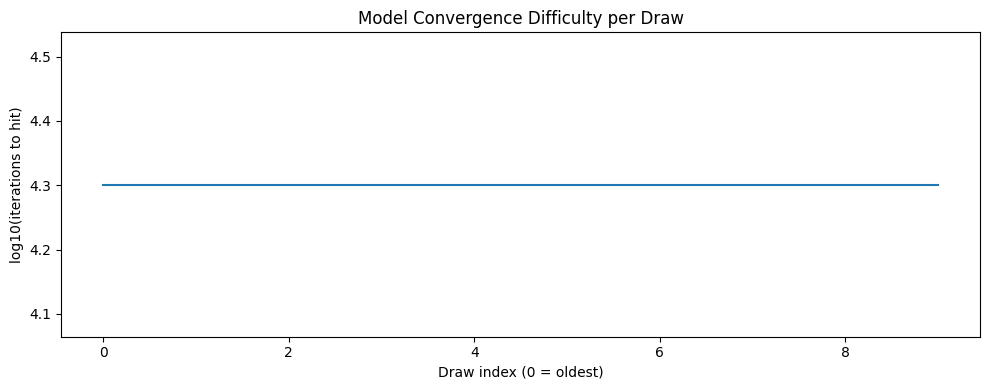

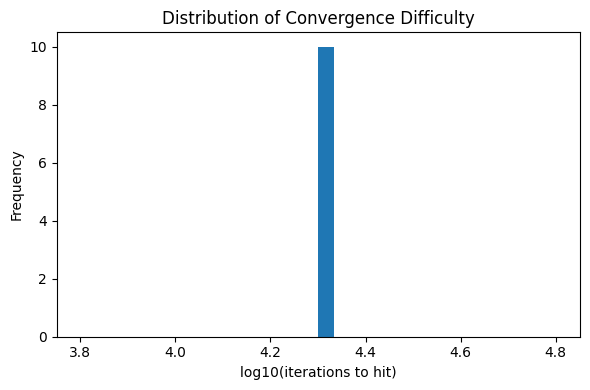

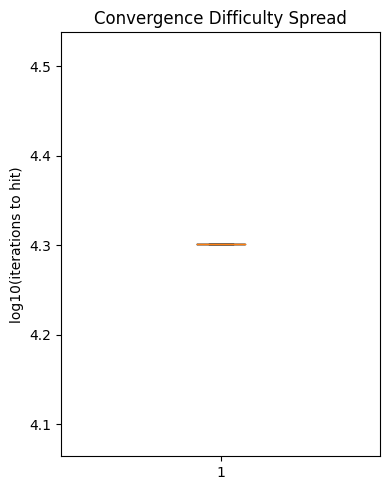

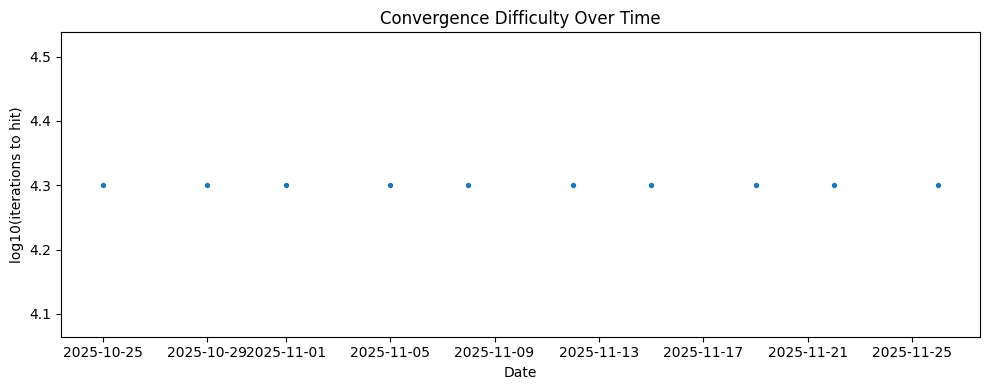

In [33]:

# === Rev15: convergence visualisation pack ===
# Requires df_convergence from build_convergence_table(...)

if "df_convergence" in globals() and df_convergence is not None and not df_convergence.empty:
    print("Head of convergence table:")
    print(df_convergence.head(20))

    # Easiest and hardest draws
    df_easy = df_convergence.sort_values("iters_to_hit").head(10)
    df_hard = df_convergence.sort_values("iters_to_hit", ascending=False).head(10)

    print("\nEasiest 10 draws for the model to hit:")
    for _, r in df_easy.iterrows():
        print(f"Draw {r['Draw']} Date={r['Date']} line={list(r['actual_line'])} "
              f"iters={int(r['iters_to_hit'])} hit={r['hit']}")

    print("\nHardest 10 draws (within the max_iter cap):")
    for _, r in df_hard.iterrows():
        print(f"Draw {r['Draw']} Date={r['Date']} line={list(r['actual_line'])} "
              f"iters={int(r['iters_to_hit'])} hit={r['hit']}")

    # 1) Time-series / index plot of log10(iters)
    plt.figure(figsize=(10, 4))
    x_axis = np.arange(len(df_convergence))
    plt.plot(x_axis, df_convergence["log10_iters"])
    plt.xlabel("Draw index (0 = oldest)")
    plt.ylabel("log10(iterations to hit)")
    plt.title("Model Convergence Difficulty per Draw")
    plt.tight_layout()
    plt.show()

    # 2) Histogram of convergence difficulty
    plt.figure(figsize=(6, 4))
    plt.hist(df_convergence["log10_iters"], bins=30)
    plt.xlabel("log10(iterations to hit)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Convergence Difficulty")
    plt.tight_layout()
    plt.show()

    # 3) Boxplot of difficulty
    plt.figure(figsize=(4, 5))
    plt.boxplot(df_convergence["log10_iters"], vert=True)
    plt.ylabel("log10(iterations to hit)")
    plt.title("Convergence Difficulty Spread")
    plt.tight_layout()
    plt.show()

    # 4) Optional: scatter of difficulty vs date (if Date is available and datetime-like)
    if "Date" in df_convergence.columns:
        try:
            dates = pd.to_datetime(df_convergence["Date"])
            plt.figure(figsize=(10, 4))
            plt.scatter(dates, df_convergence["log10_iters"], s=8)
            plt.xlabel("Date")
            plt.ylabel("log10(iterations to hit)")
            plt.title("Convergence Difficulty Over Time")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Could not plot difficulty vs Date:", e)
else:
    print("df_convergence not defined or empty. Run build_convergence_table(...) first.")


## Rev16 – TensorFlow Deep Classifier & Hybrid Resonance

In [34]:
# === Rev16: TensorFlow deep classifier + hybrid resonance + advanced analysis ===
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras import mixed_precision

    TF_AVAILABLE = True
    print("TensorFlow version:", tf.__version__)

    # Threading tweaks (adjust depending on WSL CPU cores)
    tf.config.threading.set_intra_op_parallelism_threads(4)
    tf.config.threading.set_inter_op_parallelism_threads(4)
    print("Threading config: intra=4, inter=4")

    # Enable XLA JIT for potential speedups on dense models
    tf.config.optimizer.set_jit(True)
    print("XLA JIT enabled:", tf.config.optimizer.get_jit())

    # Detect GPUs and enable memory growth (safer under WSL / CUDA)
    gpus = tf.config.list_physical_devices("GPU")
    print("TF devices:", tf.config.list_physical_devices())
    print("TF GPUs:", gpus)
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception as e:
                print("Could not set memory growth for", gpu, "->", e)

        # Enable mixed precision on CUDA GPU (good for 3080 Ti)
        mixed_precision.set_global_policy("mixed_float16")
        print("Using mixed precision policy:", mixed_precision.global_policy())
    else:
        print("No GPU visible to TF -> training will fall back to CPU.")

except ImportError:
    TF_AVAILABLE = False
    print("TensorFlow not installed; Rev16 deep model features will be skipped.")


TensorFlow version: 2.17.0
Threading config: intra=4, inter=4
XLA JIT enabled: autoclustering
TF devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using mixed precision policy: <DTypePolicy "mixed_float16">


In [35]:
# Build real vs synthetic dataset for TensorFlow classifier
# Requires: df_real_feat, df_synth_feat, feature_cols

def build_tf_training_data(df_real_feat, df_synth_feat, feature_cols, neg_to_pos_ratio: float = 1.0):
    """Prepare a binary classification dataset:
      class 1 = historical draws, class 0 = synthetic draws."""
    df_synth_local = df_synth_feat.copy()
    for col in feature_cols:
        if col not in df_synth_local.columns:
            df_synth_local[col] = 0.0

    X_pos = df_real_feat[feature_cols].to_numpy(dtype="float32")
    X_neg_full = df_synth_local[feature_cols].to_numpy(dtype="float32")

    n_pos = len(X_pos)
    n_neg_target = int(neg_to_pos_ratio * n_pos)
    if len(X_neg_full) > n_neg_target and n_neg_target > 0:
        idx = np.random.choice(len(X_neg_full), size=n_neg_target, replace=False)
        X_neg = X_neg_full[idx]
    else:
        X_neg = X_neg_full

    y_pos = np.ones((len(X_pos),), dtype="float32")
    y_neg = np.zeros((len(X_neg),), dtype="float32")

    X_all = np.concatenate([X_pos, X_neg], axis=0)
    y_all = np.concatenate([y_pos, y_neg], axis=0)

    perm = np.random.permutation(len(X_all))
    return X_all[perm], y_all[perm]

tf_model = None
if TF_AVAILABLE:
    print("Building TF real vs synthetic training data...")
    X_tf, y_tf = build_tf_training_data(df_real_feat, df_synth_feat, feature_cols, neg_to_pos_ratio=1.0)
    print("TF dataset shapes:", X_tf.shape, y_tf.shape)

    n_total_tf = len(X_tf)
    n_train_tf = int(0.8 * n_total_tf)
    X_train_tf, X_val_tf = X_tf[:n_train_tf], X_tf[n_train_tf:]
    y_train_tf, y_val_tf = y_tf[:n_train_tf], y_tf[n_train_tf:]
else:
    print("TF not available; skipping TF dataset build.")

Building TF real vs synthetic training data...
TF dataset shapes: (2928, 23) (2928,)


In [36]:
history_tf = None
if TF_AVAILABLE:
    def build_tf_model(input_dim: int):
        model = keras.Sequential(
            [
                layers.Input(shape=(input_dim,)),
                layers.BatchNormalization(),
                layers.Dense(128, activation="relu"),
                layers.Dropout(0.3),
                layers.Dense(64, activation="relu"),
                layers.Dropout(0.2),
                layers.Dense(32, activation="relu"),
                layers.Dense(1, activation="sigmoid", dtype="float32"),
            ]
        )
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss="binary_crossentropy",
            metrics=[
                "accuracy",
                keras.metrics.AUC(name="auc"),
            ],
        )
        return model

    tf_model = build_tf_model(X_train_tf.shape[1])
    print("Training TensorFlow classifier (GPU will be used if available)...")
    history_tf = tf_model.fit(
        X_train_tf,
        y_train_tf,
        validation_data=(X_val_tf, y_val_tf),
        epochs=25,
        batch_size=4096,
        verbose=2,
    )
    print(
        f"Final val: loss={history_tf.history['val_loss'][-1]:.4f}, "
        f"acc={history_tf.history['val_accuracy'][-1]:.4f}, "
        f"auc={history_tf.history['val_auc'][-1]:.4f}"
    )
else:
    print("TF not available; skipping training.")

I0000 00:00:1764589700.774349   13755 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764589700.774432   13755 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764589700.774510   13755 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764589700.777419   13755 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764589700.777458   13755 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Training TensorFlow classifier (GPU will be used if available)...
Epoch 1/25


I0000 00:00:1764589701.788674   14377 service.cc:146] XLA service 0x760b44005610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764589701.788715   14377 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
I0000 00:00:1764589701.884411   14377 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 - 4s - 4s/step - accuracy: 0.4944 - auc: 0.5000 - loss: nan - val_accuracy: 0.5222 - val_auc: 0.5000 - val_loss: nan
Epoch 2/25
1/1 - 0s - 45ms/step - accuracy: 0.4944 - auc: 0.5000 - loss: nan - val_accuracy: 0.5222 - val_auc: 0.5000 - val_loss: nan
Epoch 3/25
1/1 - 0s - 43ms/step - accuracy: 0.4944 - auc: 0.5000 - loss: nan - val_accuracy: 0.5222 - val_auc: 0.5000 - val_loss: nan
Epoch 4/25
1/1 - 0s - 41ms/step - accuracy: 0.4944 - auc: 0.5000 - loss: nan - val_accuracy: 0.5222 - val_auc: 0.5000 - val_loss: nan
Epoch 5/25
1/1 - 0s - 40ms/step - accuracy: 0.4944 - auc: 0.5000 - loss: nan - val_accuracy: 0.5222 - val_auc: 0.5000 - val_loss: nan
Epoch 6/25
1/1 - 0s - 41ms/step - accuracy: 0.4944 - auc: 0.5000 - loss: nan - val_accuracy: 0.5222 - val_auc: 0.5000 - val_loss: nan
Epoch 7/25
1/1 - 0s - 43ms/step - accuracy: 0.4944 - auc: 0.5000 - loss: nan - val_accuracy: 0.5222 - val_auc: 0.5000 - val_loss: nan
Epoch 8/25
1/1 - 0s - 42ms/step - accuracy: 0.4944 - auc: 0.5000 - loss: na

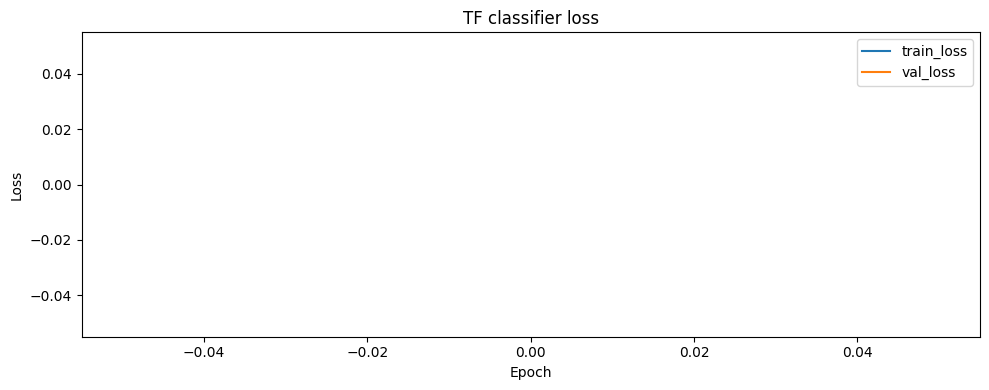

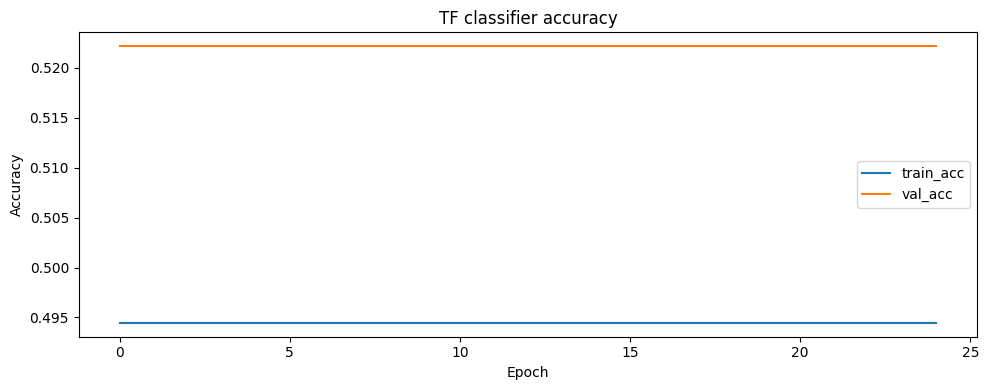

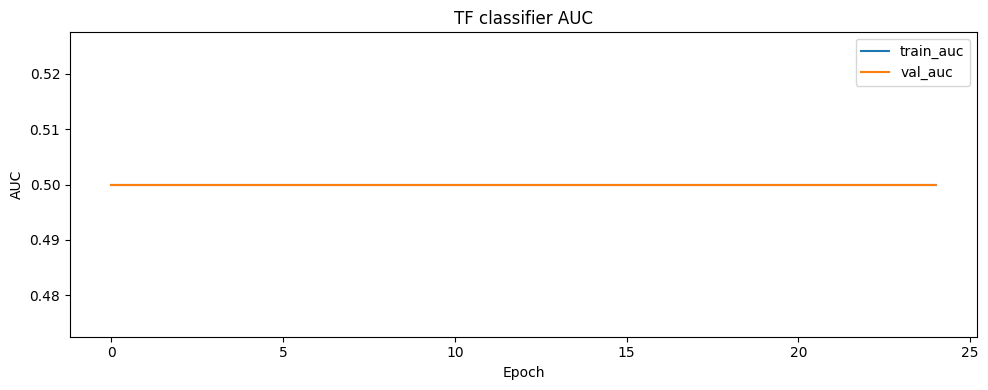

In [37]:
# Visualise TF training curves
if history_tf is not None:
    plt.figure(figsize=(10,4))
    plt.plot(history_tf.history["loss"], label="train_loss")
    plt.plot(history_tf.history["val_loss"], label="val_loss")
    plt.title("TF classifier loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(history_tf.history["accuracy"], label="train_acc")
    plt.plot(history_tf.history["val_accuracy"], label="val_acc")
    plt.title("TF classifier accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if "auc" in history_tf.history and "val_auc" in history_tf.history:
        plt.figure(figsize=(10,4))
        plt.plot(history_tf.history["auc"], label="train_auc")
        plt.plot(history_tf.history["val_auc"], label="val_auc")
        plt.title("TF classifier AUC")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("No TF history to plot.")

### Rev16 Hybrid Resonance & Advanced Line Generation

In [ ]:
# === Safe Helper: build_features_from_draw_line for TF scoring ===
def build_features_from_draw_line(line_numbers, feature_columns=None):
    """
    Build a 1-row DataFrame of features for a single Lotto line,
    using the same logic and column order as the main feature builder.

    This wrapper handles both possible signatures of your original
    build_features_from_draw(...) implementation.
    """

    if feature_columns is None:
        feature_columns = feature_cols  # global list of feature names

    # --- Case 1: Try the (line_numbers, feature_columns) signature ---
    try:
        df = build_features_from_draw(line_numbers, feature_columns)
        # Must return a DataFrame
        if hasattr(df, "columns"):
            # ensure correct column order
            return df[feature_columns]
    except TypeError:
        pass

    # --- Case 2: Try the (line_numbers) signature ---
    try:
        df = build_features_from_draw(line_numbers)
        if hasattr(df, "columns"):
            # reorder and ensure correctness
            return df[feature_columns]
    except Exception as e:
        raise RuntimeError(
            f"build_features_from_draw(...) could not be called with either signature. "
            f"Original error: {e}"
        )

    # If neither worked:
    raise RuntimeError(
        "build_features_from_draw_line() could not interpret build_features_from_draw()."
    )


In [38]:
# Hybrid resonance: combine pattern_resonance_score with TF "real-likeness" probability

def hybrid_resonance_score(line_numbers,
                           hist_profile=historical_profile,
                           bucket_count_cols=bucket_count_cols,
                           feature_cols=feature_cols,
                           tf_model=tf_model,
                           w_pattern: float = 0.5,
                           w_tf: float = 0.5):
    pattern_score, comps = pattern_resonance_score(line_numbers, hist_profile, bucket_count_cols)

    tf_prob = None
    if TF_AVAILABLE and (tf_model is not None):
        feat_df = build_features_from_draw_line(line_numbers)
        X_line = feat_df.to_numpy(dtype="float32")
        tf_prob = float(tf_model.predict(X_line, verbose=0)[0][0])
        hybrid = float(w_pattern * pattern_score + w_tf * tf_prob)
    else:
        hybrid = pattern_score

    details = {"pattern": pattern_score, "tf_prob": tf_prob}
    details.update(comps)
    return hybrid, details

print("Hybrid resonance check on a few example lines:")
example_lines = [
    [3, 8, 14, 27, 33, 38],
    [7, 9, 18, 23, 28, 38],
    [3, 8, 21, 24, 31, 34],
    [1, 2, 3, 4, 5, 6],
]
for ln in example_lines:
    h, d = hybrid_resonance_score(ln)
    print(f"  line={ln} -> hybrid={h:.3f}, pattern={d['pattern']:.3f}, tf_prob={d['tf_prob']}")

Hybrid resonance check on a few example lines:


NameError: name 'build_features_from_draw_line' is not defined

In [ ]:
# Monte Carlo generation using hybrid resonance scoring

def bulk_generate_and_score_hybrid(n_samples=5000,
                                   use_model_mc=True,
                                   top_n=50,
                                   verbose_every=1000):
    """Generate many lines, score with hybrid_resonance_score, keep top_n unique."""
    best = {}

    for i in range(1, n_samples + 1):
        line = generate_model_line(feature_cols, use_model_mc=use_model_mc)
        key = tuple(line)
        score, comps = hybrid_resonance_score(line)

        if key not in best:
            best[key] = {"score": score, "freq": 1, "components": comps}
        else:
            best[key]["freq"] += 1
            if score > best[key]["score"]:
                best[key]["score"] = score
                best[key]["components"] = comps

        if verbose_every and (i % verbose_every == 0):
            print(f"Generated and scored {i} lines...")

    records = []
    for line_t, v in best.items():
        row = {
            "line": list(line_t),
            "score": v["score"],
            "freq": v["freq"],
        }
        row.update(v["components"])
        records.append(row)

    df_lines = pd.DataFrame(records)
    df_lines = df_lines.sort_values("score", ascending=False).reset_index(drop=True)

    print(f"Top {top_n} hybrid-resonant lines (out of {n_samples} generated):\n")
    for i in range(min(top_n, len(df_lines))):
        r = df_lines.iloc[i]
        print(
            f"Rank {i+1}: line={r['line']}  score={r['score']:.3f}  freq={int(r['freq'])}  "
            f"(pattern={r['pattern']:.3f}, tf_prob={r['tf_prob']})"
        )

    return df_lines

# Example smaller run (you can scale n_samples way up):
df_top_hybrid = bulk_generate_and_score_hybrid(
    n_samples=5000,
    use_model_mc=True,
    top_n=30,
    verbose_every=1000,
)

In [ ]:
# Analyse hybrid score distributions for:
#  - Real historical draws
#  - Pure random lines
#  - Model-generated lines

def sample_lines_and_scores(num_samples, generator_fn):
    scores = []
    for _ in range(num_samples):
        ln = generator_fn()
        s, _ = hybrid_resonance_score(ln)
        scores.append(s)
    return np.array(scores)

num_samples_dist = 2000

# Real historical draws
real_scores = []
for _, row in df_real_feat.iterrows():
    line = [int(row[c]) for c in win_cols]
    s, _ = hybrid_resonance_score(line)
    real_scores.append(s)
real_scores = np.array(real_scores)

# Pure random
random_scores = sample_lines_and_scores(
    num_samples_dist,
    generator_fn=lambda: sorted(np.random.choice(np.arange(1,41), size=6, replace=False))
)

# Model-generated
model_scores = sample_lines_and_scores(
    num_samples_dist,
    generator_fn=lambda: generate_model_line(feature_cols, use_model_mc=True)
)

plt.figure(figsize=(10,5))
plt.hist(real_scores, bins=30, alpha=0.5, label="Real draws")
plt.hist(random_scores, bins=30, alpha=0.5, label="Pure random")
plt.hist(model_scores, bins=30, alpha=0.5, label="Model-generated")
plt.title("Hybrid resonance score distributions")
plt.xlabel("Hybrid score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

print("Mean hybrid scores:")
print("  Real draws   :", real_scores.mean())
print("  Random lines :", random_scores.mean())
print("  Model lines  :", model_scores.mean())


## Rev16B: TensorFlow One-Hot Real vs Synthetic Classifier (Alternative TF Model)

In this alternative Rev16B section we:

- Represent each Lotto line as a **40-dimensional one-hot vector** (1..40),
- Train a TensorFlow classifier to distinguish **real historical draws** from **synthetic draws**,
- Override the global `tf_model` with this one-hot model so that existing
  hybrid and CHAP logic can optionally use this richer representation.


In [ ]:
# === Rev16B: One-hot encoding utilities ===
import numpy as np

def line_to_onehot(line_numbers, n_numbers=40):
    """Convert a list of Lotto numbers into a 40-dim one-hot presence vector.
    Example: [3, 8, 14] -> [0,0,1,0,0,0,0,1,...]
    """
    vec = np.zeros((n_numbers,), dtype="float32"
                   )
    for n in line_numbers:
        if 1 <= n <= n_numbers:
            vec[n - 1] = 1.0
    return vec


def build_onehot_dataset(df_real, df_synth, number_cols, n_numbers=40, neg_to_pos_ratio=1.0):
    """Build a real vs synthetic dataset in one-hot space.

    df_real:  raw real draws dataframe (must contain number_cols)
    df_synth: synthetic draws dataframe (must contain number_cols)
    number_cols: list of 6 columns containing winning numbers
    neg_to_pos_ratio: how many synthetic samples (negatives) per real sample
    """
    # Real
    X_pos = []
    for _, row in df_real.iterrows():
        line = [int(row[c]) for c in number_cols]
        X_pos.append(line_to_onehot(line, n_numbers=n_numbers))
    X_pos = np.stack(X_pos, axis=0)
    y_pos = np.ones((len(X_pos),), dtype="float32")

    # Synthetic
    X_neg_full = []
    for _, row in df_synth.iterrows():
        line = [int(row[c]) for c in number_cols]
        X_neg_full.append(line_to_onehot(line, n_numbers=n_numbers))
    X_neg_full = np.stack(X_neg_full, axis=0)

    n_pos = len(X_pos)
    n_neg_target = int(neg_to_pos_ratio * n_pos)
    if len(X_neg_full) > n_neg_target and n_neg_target > 0:
        idx = np.random.choice(len(X_neg_full), size=n_neg_target, replace=False)
        X_neg = X_neg_full[idx]
    else:
        X_neg = X_neg_full

    y_neg = np.zeros((len(X_neg),), dtype="float32")

    X_all = np.concatenate([X_pos, X_neg], axis=0)
    y_all = np.concatenate([y_pos, y_neg], axis=0)

    perm = np.random.permutation(len(X_all))
    return X_all[perm], y_all[perm]


# Build one-hot dataset using df_draws (real) and df_synth (synthetic)
print("Building one-hot dataset for Rev16B TF model...")
X_onehot, y_onehot = build_onehot_dataset(df_draws, df_synth, number_cols, n_numbers=40, neg_to_pos_ratio=1.0)
print("One-hot dataset shape:", X_onehot.shape, y_onehot.shape)

from sklearn.model_selection import train_test_split
X_train_oh, X_val_oh, y_train_oh, y_val_oh = train_test_split(
    X_onehot, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot
)
print("Train one-hot shape:", X_train_oh.shape, "Val one-hot shape:", X_val_oh.shape)


In [ ]:
# === Rev16B: TensorFlow one-hot real vs synthetic classifier ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_dim_oh = X_train_oh.shape[1]

tf_onehot_model = keras.Sequential(
    [
        layers.Input(shape=(input_dim_oh,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        # Output in float32 for stability even if using mixed precision globally
        layers.Dense(1, activation="sigmoid", dtype="float32"),
    ]
)

tf_onehot_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history_oh = tf_onehot_model.fit(
    X_train_oh,
    y_train_oh,
    validation_data=(X_val_oh, y_val_oh),
    epochs=25,
    batch_size=4096,  # leverage 3080 Ti GPU with large batches
    verbose=2,
)

# Override the global tf_model so existing hybrid/CHAP logic can use this one-hot model
tf_model = tf_onehot_model
print("Global tf_model now points to the Rev16B one-hot classifier.")


In [ ]:
# === Rev16B: helper to score a single line with the one-hot TF model ===
def tf_onehot_prob_for_line(line_numbers, model=None, n_numbers=40):
    if model is None:
        model = tf_onehot_model  # default to Rev16B model
    x = line_to_onehot(line_numbers, n_numbers=n_numbers)[np.newaxis, ...]
    return float(model.predict(x, verbose=0)[0][0])


# Quick sanity check
example_lines_rev16b = [
    [3, 8, 14, 27, 33, 38],
    [1, 2, 3, 4, 5, 6],
]

print("\nRev16B one-hot TF probs:")
for ln in example_lines_rev16b:
    print(ln, "->", tf_onehot_prob_for_line(ln))
